# Libraries

In [1]:
!pip install arch

In [2]:
!pip install statsmodels

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout, LSTM, InputLayer
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from google.colab import drive
import os
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input

from tensorflow.keras.layers import Activation
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.layers import Lambda
import tensorflow as tf
from sklearn.linear_model import LinearRegression
from tensorflow.keras.callbacks import EarlyStopping



from arch import arch_model
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf



In [4]:
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/Colab Notebooks/ATSF/Cryptocurrency-Prediction-with-Artificial-Intelligence')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


LSTM and NN Config:

In [5]:
def set_np_and_tf_seed():
  # Set the seed for TensorFlow
  tf.random.set_seed(42)
  # Optionally set the seed for NumPy if you haven't set it before and if you're using NumPy arrays directly in your model
  np.random.seed(42)

set_np_and_tf_seed()

# TODO:

change epoch and num_nets for the last execution

252 => 365

Log_returns are not used in LSTM, therefore the sharpe ratios are not comparable

LPD var in lstm univariate should start at the end of august

Sharpe Ratio Simple NN (univariate)

1-Sharpe Ratio LPD von Simple NN Abs Strategy (univariate) mit Sharpe Ratio von BH
2-Sharpe Ratio LPD von Simple NN Variance Strategy (univariate) mit BH



Sharpe Ratio LSTM (univariate (close))

3-LSTM (univariate) mit BH, LPD von LSTM  Abs Strategy
4-LSTM (univariate) mit BH, LPD von LSTM Variance Strategy



Sharpe Ratio LSTM (multivariate (["High","Low","Open","close"]))

5-LSTM (multivariate) mit BH, LPD von LSTM  Abs Strategy
6-LSTM (multivariate) mit BH, LPD von LSTM Variance Strategy



7-Sharpe Ratio LSTM (univariate (close)) mit Sharpe Ratio LSTM (multivariate (["High","Low","Open","close"]))

Quantile of out of sample, take the last month of train

In [6]:
# General
year_length=365
aim="Close"


## Modeling
batch_size_nn = 32
epochs_nn=20
linear_output_nn=True
loss_nn='mean_squared_error'
shuffle_nn=True

early_stopping = EarlyStopping(
    monitor='val_loss',   # Monitor the validation loss
    min_delta=0.00001,      # Minimum change detected as an improvement
    patience=5,          # Stops after 10 epochs of no improvements
    verbose=1,            # Prints out messages
    mode='min',           # Stops when the quantity monitored has stopped decreasing
    restore_best_weights=True  # Restores model weights from the epoch with the best value of the monitored quantity.
)
lags_nn = 6

## Absolute LPD
k_nn = 1  # Example feature index
quantile_select_nn = 1 - 1/7
length_roll_quantile_nn = 30  # Using one month

## Random LPD
num_nets_nn=20



# Reading Data for our case Ethereum:

In [7]:
data_eth = pd.read_csv("eth_hist.csv")
print(data_eth.head(0))
data_eth = data_eth.loc[:,['Date','High','Low','Open','Volume',aim]]
print(data_eth.head(5))
print(data_eth.Date)

Empty DataFrame
Columns: [Date, Open, High, Low, Close, Volume, Dividends, Stock Splits]
Index: []
                        Date        High         Low        Open      Volume  \
0  2017-11-09 00:00:00+00:00  329.451996  307.056000  308.644989   893249984   
1  2017-11-10 00:00:00+00:00  324.717987  294.541992  320.670990   885985984   
2  2017-11-11 00:00:00+00:00  319.453003  298.191986  298.585999   842300992   
3  2017-11-12 00:00:00+00:00  319.153015  298.513000  314.690002  1613479936   
4  2017-11-13 00:00:00+00:00  328.415009  307.024994  307.024994  1041889984   

        Close  
0  320.884003  
1  299.252991  
2  314.681000  
3  307.907990  
4  316.716003  
0       2017-11-09 00:00:00+00:00
1       2017-11-10 00:00:00+00:00
2       2017-11-11 00:00:00+00:00
3       2017-11-12 00:00:00+00:00
4       2017-11-13 00:00:00+00:00
                  ...            
2309    2024-03-06 00:00:00+00:00
2310    2024-03-07 00:00:00+00:00
2311    2024-03-08 00:00:00+00:00
2312    2024-03-09

In [8]:
data_eth = data_eth.set_index('Date').sort_values('Date', ascending=True)
data_eth.index = pd.to_datetime(data_eth.index,unit='ns')
print(data_eth.index)

DatetimeIndex(['2017-11-09 00:00:00+00:00', '2017-11-10 00:00:00+00:00',
               '2017-11-11 00:00:00+00:00', '2017-11-12 00:00:00+00:00',
               '2017-11-13 00:00:00+00:00', '2017-11-14 00:00:00+00:00',
               '2017-11-15 00:00:00+00:00', '2017-11-16 00:00:00+00:00',
               '2017-11-17 00:00:00+00:00', '2017-11-18 00:00:00+00:00',
               ...
               '2024-03-01 00:00:00+00:00', '2024-03-02 00:00:00+00:00',
               '2024-03-03 00:00:00+00:00', '2024-03-04 00:00:00+00:00',
               '2024-03-05 00:00:00+00:00', '2024-03-06 00:00:00+00:00',
               '2024-03-07 00:00:00+00:00', '2024-03-08 00:00:00+00:00',
               '2024-03-09 00:00:00+00:00', '2024-03-10 00:00:00+00:00'],
              dtype='datetime64[ns, UTC]', name='Date', length=2314, freq=None)


In [9]:
train_data_eth = data_eth.iloc[:-200]
test_data_eth = data_eth.iloc[-200:]


def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('ETH', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16);

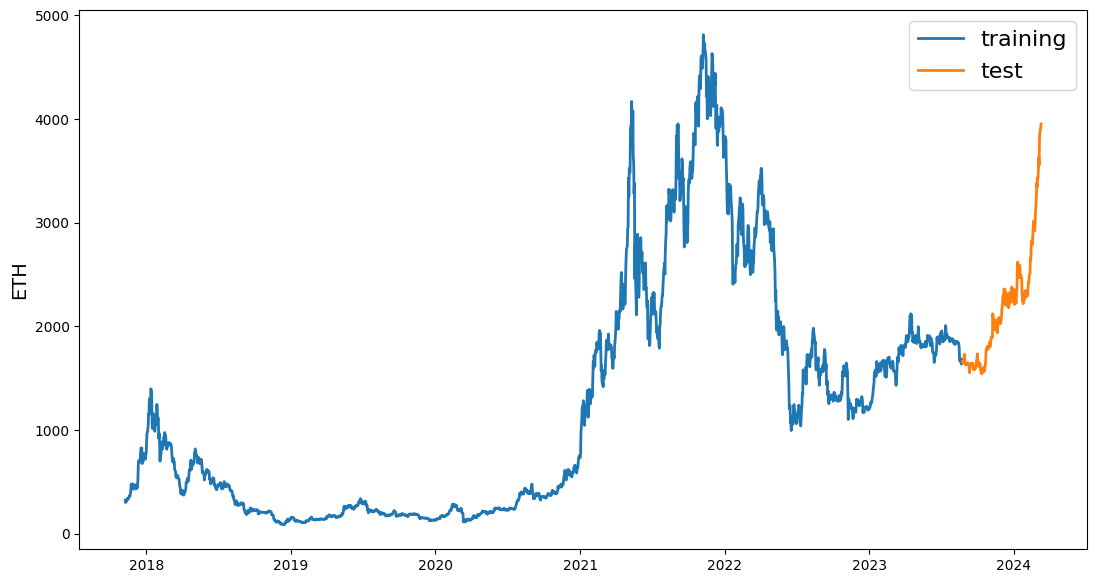

In [10]:
line_plot(train_data_eth[aim], test_data_eth[aim], 'training', 'test', title='')

# Univariate Data processing and Data modeling (Simple NN) for Ethereum dataset in addition to using LPD

Only using close column for Data processing and Data modeling. For Data modeling we use simple NN with one hidden Layer. We also use LPD to gain Explainability and also to derive Strategies

## Data Preprocessing

In [11]:
train_data_eth.head(10)

High         Low        Open      Volume  \
Date                                                                        
2017-11-09 00:00:00+00:00  329.451996  307.056000  308.644989   893249984   
2017-11-10 00:00:00+00:00  324.717987  294.541992  320.670990   885985984   
2017-11-11 00:00:00+00:00  319.453003  298.191986  298.585999   842300992   
2017-11-12 00:00:00+00:00  319.153015  298.513000  314.690002  1613479936   
2017-11-13 00:00:00+00:00  328.415009  307.024994  307.024994  1041889984   
2017-11-14 00:00:00+00:00  340.177002  316.763000  316.763000  1069680000   
2017-11-15 00:00:00+00:00  340.911987  329.812988  337.963989   722665984   
2017-11-16 00:00:00+00:00  336.158997  323.605988  333.442993   797254016   
2017-11-17 00:00:00+00:00  334.963989  327.523010  330.166992   621732992   
2017-11-18 00:00:00+00:00  349.615997  327.687012  331.980011   649638976   

                                Close  
Date                                   
2017-11-09 00:00:00+00:00  320.884003  
2017-11-10 00:00:00+00:00  299.252991  
2017-11-11 00:00:00+00:00  314.681000  
2017-11-12 00:00:00+00:00  307.907990  
2017-11-13 00:00:00+00:00  316.716003  
2017-11-14 00:00:00+00:00  337.631012  
2017-11-15 00:00:00+00:00  333.356995  
2017-11-16 00:00:00+00:00  330.924011  
2017-11-17 00:00:00+00:00  332.394012  
2017-11-18 00:00:00+00:00  347.612000

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002414. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


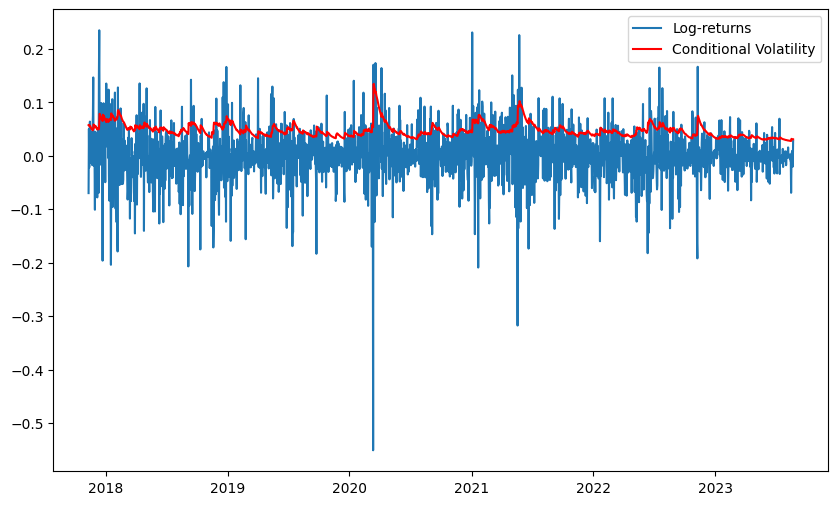

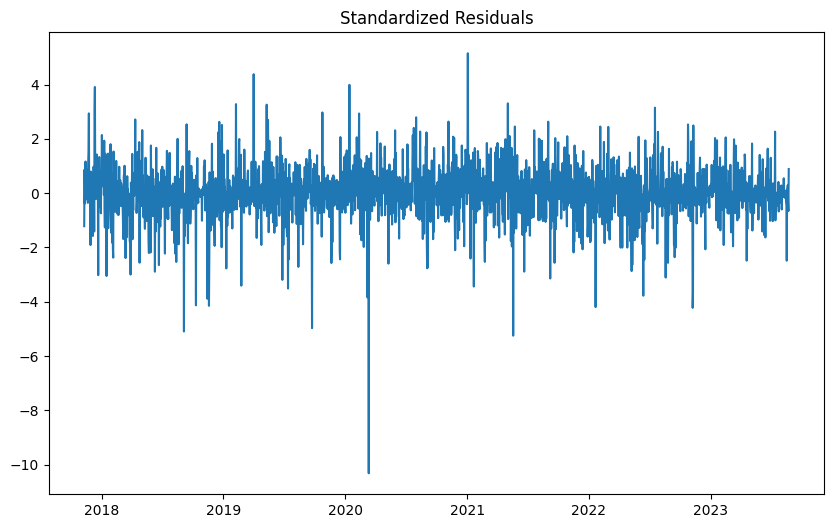

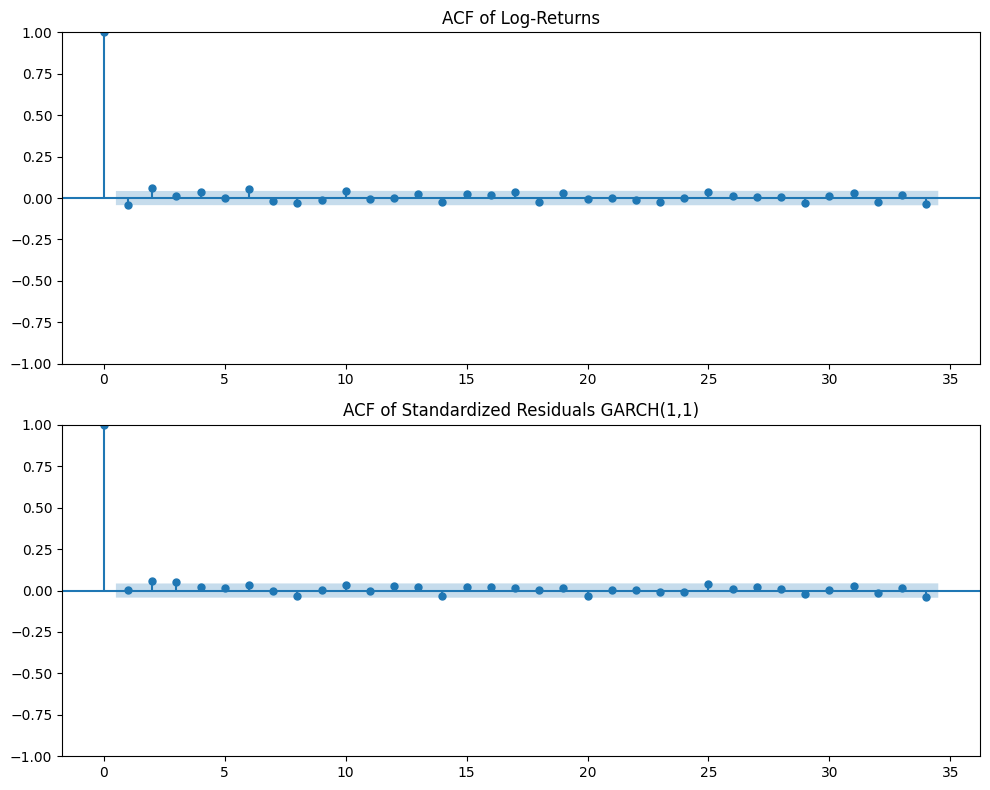

In [12]:
# Calculate log returns
log_returns_nn = np.log(train_data_eth[aim]).diff().dropna()

# 2.a Fit a GARCH(1, 1) model
garch_11_nn = arch_model(log_returns_nn, vol='Garch', p=1, q=1, mean='zero').fit(disp='off')

# Plotting the series and the conditional volatility
plt.figure(figsize=(10, 6))
plt.plot(log_returns_nn, label='Log-returns')
plt.plot(garch_11_nn.conditional_volatility, color='red', label='Conditional Volatility')
plt.legend()
plt.show()

# 2.b Plot standardized residuals
standard_residuals_nn = garch_11_nn.resid / garch_11_nn.conditional_volatility
plt.figure(figsize=(10, 6))
plt.plot(standard_residuals_nn)
plt.title('Standardized Residuals')
plt.show()

# 2.c Autocorrelation plots
fig, axes = plt.subplots(2, 1, figsize=(10, 8))
plot_acf(log_returns_nn, ax=axes[0], title="ACF of Log-Returns")
plot_acf(standard_residuals_nn, ax=axes[1], title="ACF of Standardized Residuals GARCH(1,1)")
plt.tight_layout()
plt.show()




In [13]:
acf(log_returns_nn)

array([ 1.00000000e+00, -4.32555801e-02,  5.81523060e-02,  1.45776235e-02,
        3.36316600e-02,  8.05956970e-04,  5.49098592e-02, -1.66879241e-02,
       -3.16095027e-02, -9.80216252e-03,  4.10486526e-02, -6.20477610e-03,
        1.63295733e-03,  2.23684019e-02, -2.37146659e-02,  2.33920114e-02,
        1.61263972e-02,  3.88778563e-02, -2.23609915e-02,  3.06862135e-02,
       -3.42415090e-03,  2.31111915e-03, -1.15993048e-02, -2.33440037e-02,
        1.90685686e-03,  3.71719153e-02,  1.25394900e-02,  7.97261776e-03,
        7.34139845e-03, -3.19731124e-02,  1.16038993e-02,  2.80578544e-02,
       -2.48281231e-02,  1.81980509e-02])

Out of Sample

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006147. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


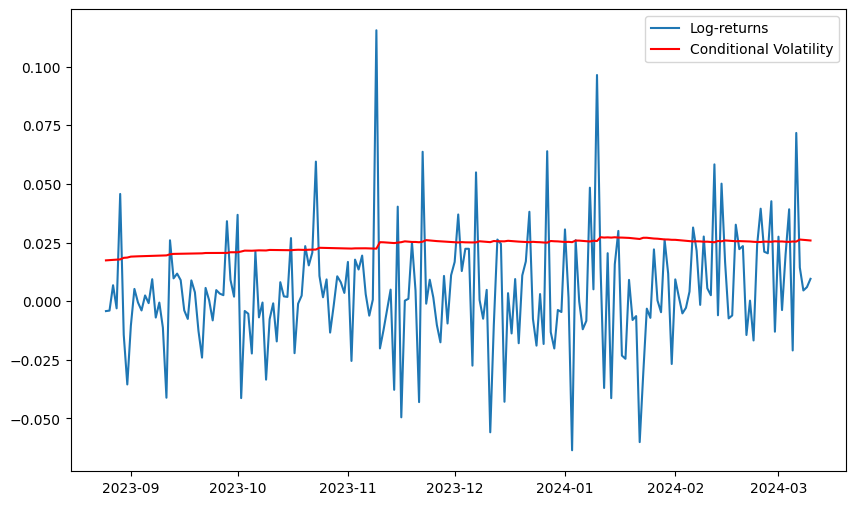

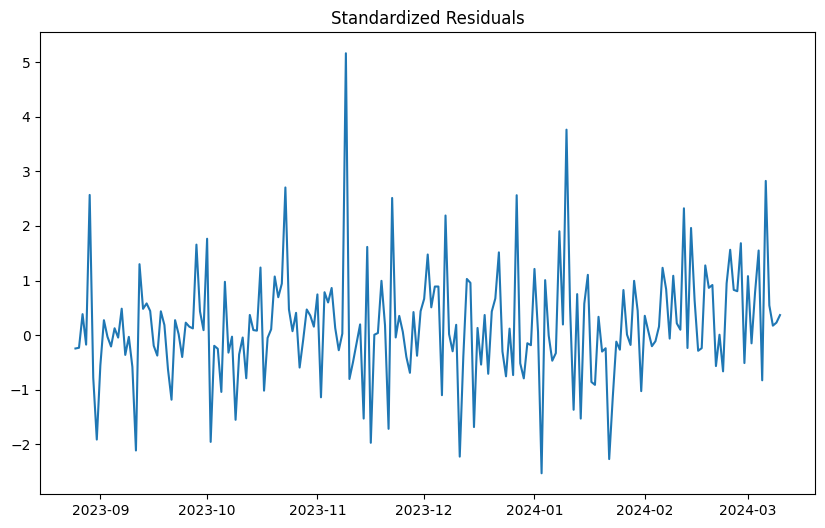

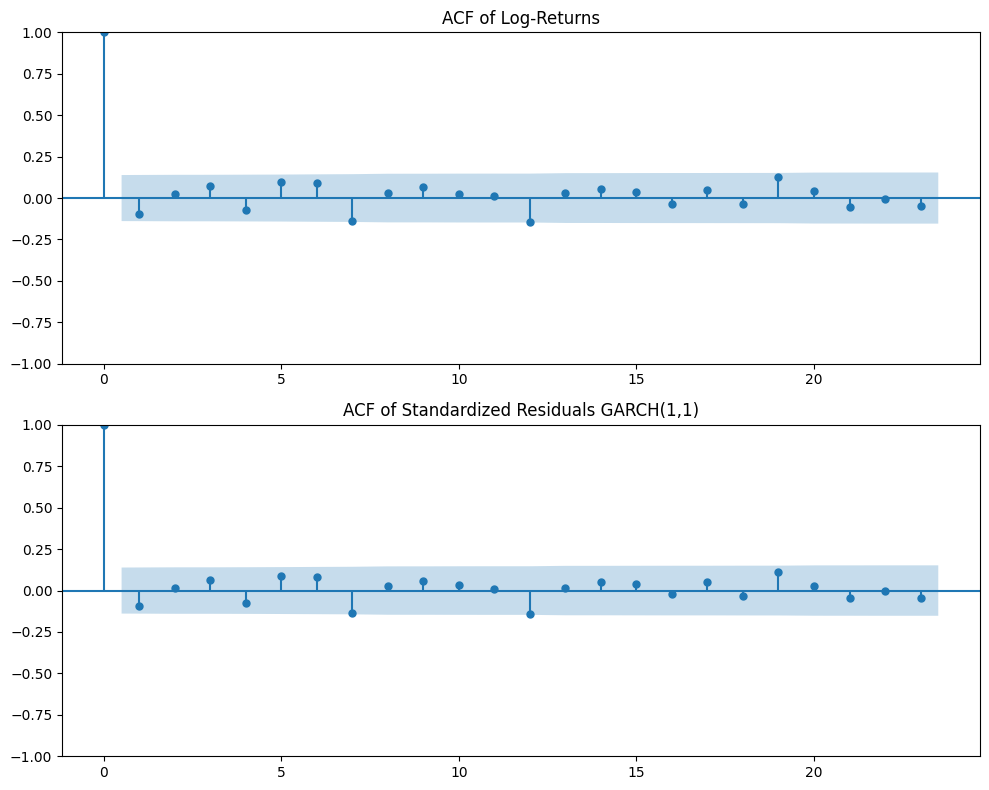

In [14]:
log_returns_test_nn = np.log(test_data_eth[aim]).diff().dropna()
# Calculate log returns

# 2.a Fit a GARCH(1, 1) model
garch_11_test_nn = arch_model(log_returns_test_nn, vol='Garch', p=1, q=1, mean='zero').fit(disp='off')

# Plotting the series and the conditional volatility
plt.figure(figsize=(10, 6))
plt.plot(log_returns_test_nn, label='Log-returns')
plt.plot(garch_11_test_nn.conditional_volatility, color='red', label='Conditional Volatility')
plt.legend()
plt.show()

# 2.b Plot standardized residuals
standard_residuals_test_nn = garch_11_test_nn.resid / garch_11_test_nn.conditional_volatility
plt.figure(figsize=(10, 6))
plt.plot(standard_residuals_test_nn)
plt.title('Standardized Residuals')
plt.show()

# 2.c Autocorrelation plots
fig, axes = plt.subplots(2, 1, figsize=(10, 8))
plot_acf(log_returns_test_nn, ax=axes[0], title="ACF of Log-Returns")
plot_acf(standard_residuals_test_nn, ax=axes[1], title="ACF of Standardized Residuals GARCH(1,1)")
plt.tight_layout()
plt.show()




As we see from below, we have 6 significant lags

In [15]:
# Generate lagged features, Based on ACF from above we choose lag 6
features_nn = pd.concat([log_returns_nn.shift(i) for i in range(lags_nn+1)], axis=1)
features_nn.columns = ['lag_' + str(i) if i != 0 else 'current_return' for i in range(lags_nn+1)]
features_nn.dropna(inplace=True)

# Display the prepared dataset
features_nn

current_return     lag_1     lag_2     lag_3  \
Date                                                                      
2017-11-16 00:00:00+00:00       -0.007325 -0.012740  0.063948  0.028204   
2017-11-17 00:00:00+00:00        0.004432 -0.007325 -0.012740  0.063948   
2017-11-18 00:00:00+00:00        0.044766  0.004432 -0.007325 -0.012740   
2017-11-19 00:00:00+00:00        0.019300  0.044766  0.004432 -0.007325   
2017-11-20 00:00:00+00:00        0.034239  0.019300  0.044766  0.004432   
...                                   ...       ...       ...       ...   
2023-08-19 00:00:00+00:00        0.005121 -0.014339 -0.069200 -0.011713   
2023-08-20 00:00:00+00:00        0.009170  0.005121 -0.014339 -0.069200   
2023-08-21 00:00:00+00:00       -0.010491  0.009170  0.005121 -0.014339   
2023-08-22 00:00:00+00:00       -0.020222 -0.010491  0.009170  0.005121   
2023-08-23 00:00:00+00:00        0.027397 -0.020222 -0.010491  0.009170   

                              lag_4     lag_5     lag_6  
Date                                                     
2017-11-16 00:00:00+00:00 -0.021758  0.050270 -0.069790  
2017-11-17 00:00:00+00:00  0.028204 -0.021758  0.050270  
2017-11-18 00:00:00+00:00  0.063948  0.028204 -0.021758  
2017-11-19 00:00:00+00:00 -0.012740  0.063948  0.028204  
2017-11-20 00:00:00+00:00 -0.007325 -0.012740  0.063948  
...                             ...       ...       ...  
2023-08-19 00:00:00+00:00 -0.009399  0.002664 -0.005211  
2023-08-20 00:00:00+00:00 -0.011713 -0.009399  0.002664  
2023-08-21 00:00:00+00:00 -0.069200 -0.011713 -0.009399  
2023-08-22 00:00:00+00:00 -0.014339 -0.069200 -0.011713  
2023-08-23 00:00:00+00:00  0.005121 -0.014339 -0.069200  

[2107 rows x 7 columns]

In [16]:
# Generate lagged features, Based on ACF from above we choose lag 6
features_test_nn = pd.concat([log_returns_test_nn.shift(i) for i in range(lags_nn+1)], axis=1)
features_test_nn.columns = ['lag_' + str(i) if i != 0 else 'current_return' for i in range(lags_nn+1)]
features_test_nn.dropna(inplace=True)

# Display the prepared dataset
features_test_nn

current_return     lag_1     lag_2     lag_3  \
Date                                                                      
2023-08-31 00:00:00+00:00       -0.035502 -0.014332  0.045699 -0.003055   
2023-09-01 00:00:00+00:00       -0.010475 -0.035502 -0.014332  0.045699   
2023-09-02 00:00:00+00:00        0.005227 -0.010475 -0.035502 -0.014332   
2023-09-03 00:00:00+00:00       -0.000555  0.005227 -0.010475 -0.035502   
2023-09-04 00:00:00+00:00       -0.003958 -0.000555  0.005227 -0.010475   
...                                   ...       ...       ...       ...   
2024-03-06 00:00:00+00:00        0.071703 -0.021007  0.039166  0.019947   
2024-03-07 00:00:00+00:00        0.014329  0.071703 -0.021007  0.039166   
2024-03-08 00:00:00+00:00        0.004562  0.014329  0.071703 -0.021007   
2024-03-09 00:00:00+00:00        0.005983  0.004562  0.014329  0.071703   
2024-03-10 00:00:00+00:00        0.009521  0.005983  0.004562  0.014329   

                              lag_4     lag_5     lag_6  
Date                                                     
2023-08-31 00:00:00+00:00  0.006784 -0.004018 -0.004232  
2023-09-01 00:00:00+00:00 -0.003055  0.006784 -0.004018  
2023-09-02 00:00:00+00:00  0.045699 -0.003055  0.006784  
2023-09-03 00:00:00+00:00 -0.014332  0.045699 -0.003055  
2023-09-04 00:00:00+00:00 -0.035502 -0.014332  0.045699  
...                             ...       ...       ...  
2024-03-06 00:00:00+00:00 -0.003793  0.027487 -0.013016  
2024-03-07 00:00:00+00:00  0.019947 -0.003793  0.027487  
2024-03-08 00:00:00+00:00  0.039166  0.019947 -0.003793  
2024-03-09 00:00:00+00:00 -0.021007  0.039166  0.019947  
2024-03-10 00:00:00+00:00  0.071703 -0.021007  0.039166  

[193 rows x 7 columns]

MinMax scaling, which rescales features to a [0,1] range, can be quite beneficial for many machine learning algorithms, including neural networks. This technique helps in speeding up the training process and achieving better performance by ensuring that features contribute equally during the computation, which is particularly important for models that are sensitive to the scale of the input data, like neural networks.

However, MinMax scaling is not without its downsides:

  Sensitivity to Outliers: MinMax scaling is highly sensitive to outliers. Since it scales all the data points within the range defined by the minimum and maximum values in the feature, a single outlier can skew the range significantly, leading to a compressed representation of the "normal" data.
  Distorted Distributions: If the data is not uniformly distributed, MinMax scaling can compress the bulk of the data into a narrow region, which might affect the performance of some algorithms that are sensitive to data distribution.

Lets avoid Scaling

In [17]:

# Lets avoid Scaling
# scaler = MinMaxScaler(feature_range=(-1, 1))
# scaled_fit = scaler.fit(features)
# scaled_features = scaled_fit.transform(features)
# scaled_features_test = scaled_fit.transform(features_test)



# Convert back to DataFrame for easier handling
# scaled_features_df = pd.DataFrame(scaled_features, index=features.index, columns=features.columns)
# scaled_features_df_test = pd.DataFrame(scaled_features_test, index=features_test.index, columns=features_test.columns)


# train_set_eth_nn = scaled_features_df
# test_set_eth_nn = scaled_features_df_test




# x_train_eth_nn = train_set_eth_nn.drop(['current_return'], axis=1)
# y_train_eth_nn = train_set_eth_nn['current_return']
# x_test_eth_nn = test_set_eth_nn.drop(['current_return'], axis=1)
# y_test_eth_nn = test_set_eth_nn['current_return']

# # Print shapes of the datasets
# print(f'x_train_eth_nn shape: {x_train_eth_nn.shape}, y_train_eth_nn shape: {y_train_eth_nn.shape}')
# print(f'x_test_eth_nn shape: {x_test_eth_nn.shape}, y_test_eth_nn shape: {y_test_eth_nn.shape}')

Remove the following if you use the above cell for scaling

In [18]:
x_train_eth_nn = features_nn.drop(['current_return'], axis=1)
y_train_eth_nn = features_nn['current_return']
x_test_eth_nn = features_test_nn.drop(['current_return'], axis=1)
y_test_eth_nn = features_test_nn['current_return']

# Print shapes of the datasets
print(f'x_train_eth_nn shape: {x_train_eth_nn.shape}, y_train_eth_nn shape: {y_train_eth_nn.shape}')
print(f'x_test_eth_nn shape: {x_test_eth_nn.shape}, y_test_eth_nn shape: {y_test_eth_nn.shape}')

x_train_eth_nn shape: (2107, 6), y_train_eth_nn shape: (2107,)
x_test_eth_nn shape: (193, 6), y_test_eth_nn shape: (193,)


## NN Model

In [19]:
def create_model(input_shape, linear_output=True, atan_not_sigmoid=False):
    """
    Creates a simple Keras model.

    Args:
    - input_shape: Shape of the input data.
    - linear_output: If True, the output layer is linear, otherwise it uses sigmoid or atan.
    - atan_not_sigmoid: If True and linear_output is False, use atan activation in the output layer.

    Returns:
    - A compiled Keras model.
    """
    model = Sequential([
        InputLayer(input_shape=input_shape),
        Dense(64, activation='relu'),
        Dense(1)
    ])

    if not linear_output:
        if atan_not_sigmoid:
            model.add(Lambda(atan_activation))
            model.compile(optimizer='adam', loss='mean_squared_error')
        else:
            # Use sigmoid for binary classification
            model.add(Dense(1, activation='sigmoid'))
            model.compile(optimizer='adam', loss='binary_crossentropy')
    else:
        # Linear output for regression
        model.compile(optimizer='adam', loss='mean_squared_error')

    return model

# Example usage:
# For a regression model:
# model = create_model(input_shape=(10,), linear_output=True)
# For a binary classification model using atan:
# model = create_model(input_shape=(10,), linear_output=False, atan_not_sigmoid=True)
# For a binary classification model using sigmoid:
# model = create_model(input_shape=(10,), linear_output=False, atan_not_sigmoid=False)


In [20]:
model_eth_nn = create_model(input_shape=(x_train_eth_nn.shape[1],), linear_output=linear_output_nn)
model_eth_nn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                448       
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 513 (2.00 KB)
Trainable params: 513 (2.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [21]:
modelfit_eth_nn = model_eth_nn.fit(
    x_train_eth_nn, y_train_eth_nn,
    validation_data=(x_test_eth_nn, y_test_eth_nn),
    epochs=epochs_nn,
    batch_size=batch_size_nn,
    verbose=1,
    shuffle=shuffle_nn,
    callbacks=[early_stopping]
)

Epoch 1/20
66/66 [==============================] - 2s 10ms/step - loss: 0.0025 - val_loss: 6.8744e-04
Epoch 2/20
66/66 [==============================] - 0s 7ms/step - loss: 0.0024 - val_loss: 6.3546e-04
Epoch 3/20
66/66 [==============================] - 0s 5ms/step - loss: 0.0024 - val_loss: 6.3807e-04
Epoch 4/20
66/66 [==============================] - 0s 5ms/step - loss: 0.0023 - val_loss: 6.3363e-04
Epoch 5/20
66/66 [==============================] - 0s 5ms/step - loss: 0.0023 - val_loss: 6.2432e-04
Epoch 6/20
66/66 [==============================] - 0s 4ms/step - loss: 0.0023 - val_loss: 6.9059e-04
Epoch 7/20
66/66 [==============================] - 0s 5ms/step - loss: 0.0023 - val_loss: 6.5964e-04
Epoch 8/20
66/66 [==============================] - 0s 5ms/step - loss: 0.0023 - val_loss: 6.3197e-04
Epoch 9/20
66/66 [==============================] - 0s 4ms/step - loss: 0.0023 - val_loss: 6.3762e-04
Epoch 10/20
66/66 [==============================] - 0s 4ms/step - loss: 0.0023 -

In [22]:
x_train_eth_nn

lag_1     lag_2     lag_3     lag_4     lag_5  \
Date                                                                          
2017-11-16 00:00:00+00:00 -0.012740  0.063948  0.028204 -0.021758  0.050270   
2017-11-17 00:00:00+00:00 -0.007325 -0.012740  0.063948  0.028204 -0.021758   
2017-11-18 00:00:00+00:00  0.004432 -0.007325 -0.012740  0.063948  0.028204   
2017-11-19 00:00:00+00:00  0.044766  0.004432 -0.007325 -0.012740  0.063948   
2017-11-20 00:00:00+00:00  0.019300  0.044766  0.004432 -0.007325 -0.012740   
...                             ...       ...       ...       ...       ...   
2023-08-19 00:00:00+00:00 -0.014339 -0.069200 -0.011713 -0.009399  0.002664   
2023-08-20 00:00:00+00:00  0.005121 -0.014339 -0.069200 -0.011713 -0.009399   
2023-08-21 00:00:00+00:00  0.009170  0.005121 -0.014339 -0.069200 -0.011713   
2023-08-22 00:00:00+00:00 -0.010491  0.009170  0.005121 -0.014339 -0.069200   
2023-08-23 00:00:00+00:00 -0.020222 -0.010491  0.009170  0.005121 -0.014339   

                              lag_6  
Date                                 
2017-11-16 00:00:00+00:00 -0.069790  
2017-11-17 00:00:00+00:00  0.050270  
2017-11-18 00:00:00+00:00 -0.021758  
2017-11-19 00:00:00+00:00  0.028204  
2017-11-20 00:00:00+00:00  0.063948  
...                             ...  
2023-08-19 00:00:00+00:00 -0.005211  
2023-08-20 00:00:00+00:00  0.002664  
2023-08-21 00:00:00+00:00 -0.009399  
2023-08-22 00:00:00+00:00 -0.011713  
2023-08-23 00:00:00+00:00 -0.069200  

[2107 rows x 6 columns]

## LPD (Linear Parameter Data)

We don't use atan_activation in this notebook

In [23]:
# Define a custom activation function using TensorFlow's atan
def atan_activation(x):
    return tf.math.atan(x)

In [24]:
def compute_lpd_with_dates(model, input_data, linear_output=True, atan_not_sigmoid=False):
    """
    Compute the Linear Parameter Data (LPD) for a given Keras model, including date information.

    Args:
    - model: Trained Keras model.
    - input_data: Input data (pandas DataFrame) for which to compute the LPD.
    - linear_output: Boolean indicating if the output layer is linear.

    Returns:
    - LPDs: Linear Parameter Data for each input data point, including date information.
    """
    # Extract dates from the input DataFrame
    dates = input_data.index

    # Ensure input_data is a TensorFlow tensor, excluding the date index for computation
    input_tensor = tf.convert_to_tensor(input_data.values, dtype=tf.float32)

    # Initialize an empty list to store LPD for each data point
    lpd_list = []

    # Compute LPD for each data point
    for i in range(input_tensor.shape[0]):
        single_input_data = tf.expand_dims(input_tensor[i], axis=0)

        with tf.GradientTape() as tape:
            tape.watch(single_input_data)
            predictions = model(single_input_data)

            if not linear_output:
                if atan_not_sigmoid:
                    predictions = atan_activation(predictions)
                else:

                    pass

        gradients = tape.gradient(predictions, single_input_data)
        lpd_list.append(gradients)

    # Convert the list of LPDs to a NumPy array and then to a DataFrame
    lpd_array = tf.concat(lpd_list, axis=0).numpy()
    lpd_df = pd.DataFrame(lpd_array, columns=input_data.columns, index=dates)

    return lpd_df



### In sample LPD:

In [25]:
lpd_train_df_nn = compute_lpd_with_dates(model_eth_nn, x_train_eth_nn)
lpd_train_df_nn

lag_1     lag_2     lag_3     lag_4     lag_5  \
Date                                                                          
2017-11-16 00:00:00+00:00  0.238832  0.065132  0.048014  0.081639  0.002591   
2017-11-17 00:00:00+00:00 -0.087469 -0.044101 -0.023818 -0.136699 -0.076636   
2017-11-18 00:00:00+00:00  0.154375  0.167627  0.043036 -0.129263  0.138302   
2017-11-19 00:00:00+00:00  0.140503  0.169435  0.052965 -0.020628 -0.006672   
2017-11-20 00:00:00+00:00  0.088648  0.019218  0.138729  0.089496  0.038985   
...                             ...       ...       ...       ...       ...   
2023-08-19 00:00:00+00:00 -0.059998 -0.013876  0.205438  0.036901  0.017335   
2023-08-20 00:00:00+00:00  0.197331  0.122262  0.060304  0.087049 -0.052883   
2023-08-21 00:00:00+00:00  0.089003  0.081236  0.125032  0.079217 -0.074606   
2023-08-22 00:00:00+00:00  0.023947  0.093704  0.101326  0.097558 -0.014540   
2023-08-23 00:00:00+00:00  0.040981  0.062935  0.025822 -0.144704 -0.009340   

                              lag_6  
Date                                 
2017-11-16 00:00:00+00:00  0.001279  
2017-11-17 00:00:00+00:00  0.111243  
2017-11-18 00:00:00+00:00  0.049571  
2017-11-19 00:00:00+00:00 -0.049349  
2017-11-20 00:00:00+00:00 -0.082837  
...                             ...  
2023-08-19 00:00:00+00:00  0.132011  
2023-08-20 00:00:00+00:00  0.046963  
2023-08-21 00:00:00+00:00 -0.033339  
2023-08-22 00:00:00+00:00  0.034122  
2023-08-23 00:00:00+00:00 -0.021583  

[2107 rows x 6 columns]

In [26]:
lpd_test_df_nn = compute_lpd_with_dates(model_eth_nn, x_test_eth_nn)
lpd_test_df_nn

lag_1     lag_2     lag_3     lag_4     lag_5  \
Date                                                                          
2023-08-31 00:00:00+00:00  0.203200  0.173443  0.077866  0.143356  0.018319   
2023-09-01 00:00:00+00:00  0.096589  0.034059  0.098732  0.010021 -0.001727   
2023-09-02 00:00:00+00:00  0.054106  0.087834  0.082920 -0.145834 -0.063230   
2023-09-03 00:00:00+00:00  0.172618  0.165181  0.281137  0.147200  0.136393   
2023-09-04 00:00:00+00:00  0.205092 -0.003029  0.190146  0.177708 -0.006815   
...                             ...       ...       ...       ...       ...   
2024-03-06 00:00:00+00:00  0.215981  0.086958  0.186306  0.070916  0.023082   
2024-03-07 00:00:00+00:00  0.053095  0.057476  0.009014 -0.105674  0.121109   
2024-03-08 00:00:00+00:00  0.108165  0.185100 -0.079452 -0.144169 -0.016490   
2024-03-09 00:00:00+00:00  0.087324  0.145746  0.016889 -0.045253  0.079140   
2024-03-10 00:00:00+00:00  0.051640  0.061254  0.026019 -0.169989 -0.002834   

                              lag_6  
Date                                 
2023-08-31 00:00:00+00:00  0.110415  
2023-09-01 00:00:00+00:00  0.083568  
2023-09-02 00:00:00+00:00  0.169219  
2023-09-03 00:00:00+00:00 -0.001406  
2023-09-04 00:00:00+00:00  0.046940  
...                             ...  
2024-03-06 00:00:00+00:00  0.116496  
2024-03-07 00:00:00+00:00  0.066414  
2024-03-08 00:00:00+00:00 -0.060094  
2024-03-09 00:00:00+00:00  0.034473  
2024-03-10 00:00:00+00:00  0.004115  

[193 rows x 6 columns]

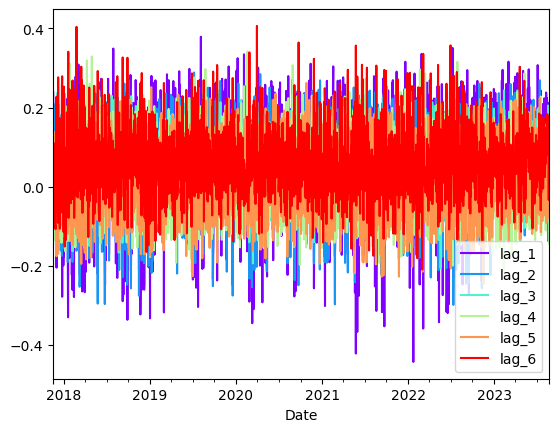

In [27]:
import matplotlib.pyplot as plt

# Plotting in-sample LPD; replace `in_sample_lpd_df` with your actual LPD DataFrame
lpd_train_df_nn.plot(colormap='rainbow')
plt.show()


### Out of sample LPD:

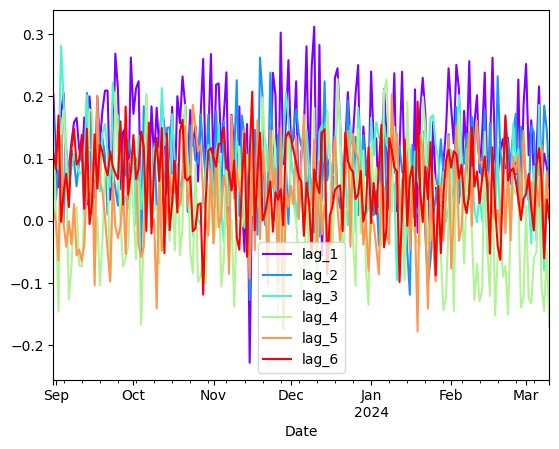

In [28]:
lpd_test_df_nn.plot(colormap='rainbow')
plt.show()


## Linear Regression vs LPD

In sample

In [29]:
# Assuming y_train_eth_nn and x_train_eth_nn are correctly defined
reg_model_nn = LinearRegression().fit(x_train_eth_nn, y_train_eth_nn)

# Regression coefficients
reg_coeffs_nn = reg_model_nn.coef_
print("Regression Coefficients:", reg_coeffs_nn)

# Assuming you've computed the LPD for your training data and stored it in a DataFrame named `lpd_train_df`
mean_lpd_nn = lpd_train_df_nn.mean(axis=0)
print("Mean LPD:", mean_lpd_nn.values)

# Comparing standard deviations of residuals from regression and your neural network model might require storing those residuals first
reg_residuals_std_nn = np.std(reg_model_nn.predict(x_train_eth_nn) - y_train_eth_nn)
print("Standard Deviation of Regression Residuals:", reg_residuals_std_nn)


Regression Coefficients: [-0.04196185  0.05354725  0.01932754  0.03018423  0.00364771  0.05128444]
Mean LPD: [0.05598946 0.06052742 0.05543968 0.029016   0.0135554  0.05860862]
Standard Deviation of Regression Residuals: 0.04891349523215928


Out of sample

In [30]:
# Assuming y_train_eth_nn and x_train_eth_nn are correctly defined
reg_model_test_nn = LinearRegression().fit(x_test_eth_nn, y_test_eth_nn)

# Regression coefficients
reg_coeffs_test_nn = reg_model_test_nn.coef_
print("Regression Coefficients test:", reg_coeffs_test_nn)

# Assuming you've computed the LPD for your training data and stored it in a DataFrame named `lpd_train_df`
mean_lpd_test_nn = lpd_test_df_nn.mean(axis=0)
print("Mean LPD test:", mean_lpd_test_nn.values)

# Comparing standard deviations of residuals from regression and your neural network model might require storing those residuals first
reg_residuals_std_test_nn = np.std(reg_model_nn.predict(x_test_eth_nn) - y_test_eth_nn)
print("Standard Deviation of Regression Residuals test:", reg_residuals_std_test_nn)


Regression Coefficients test: [-0.0910961   0.02559589  0.06390736 -0.05162919  0.09441521  0.11081833]
Mean LPD test: [0.12932892 0.08489709 0.07743526 0.01047338 0.03471306 0.06228535]
Standard Deviation of Regression Residuals test: 0.024801470237936395


## Buy and Hold vs LPD:

Features were calculate as follows the following cell before

In [31]:
features_nn

current_return     lag_1     lag_2     lag_3  \
Date                                                                      
2017-11-16 00:00:00+00:00       -0.007325 -0.012740  0.063948  0.028204   
2017-11-17 00:00:00+00:00        0.004432 -0.007325 -0.012740  0.063948   
2017-11-18 00:00:00+00:00        0.044766  0.004432 -0.007325 -0.012740   
2017-11-19 00:00:00+00:00        0.019300  0.044766  0.004432 -0.007325   
2017-11-20 00:00:00+00:00        0.034239  0.019300  0.044766  0.004432   
...                                   ...       ...       ...       ...   
2023-08-19 00:00:00+00:00        0.005121 -0.014339 -0.069200 -0.011713   
2023-08-20 00:00:00+00:00        0.009170  0.005121 -0.014339 -0.069200   
2023-08-21 00:00:00+00:00       -0.010491  0.009170  0.005121 -0.014339   
2023-08-22 00:00:00+00:00       -0.020222 -0.010491  0.009170  0.005121   
2023-08-23 00:00:00+00:00        0.027397 -0.020222 -0.010491  0.009170   

                              lag_4     lag_5     lag_6  
Date                                                     
2017-11-16 00:00:00+00:00 -0.021758  0.050270 -0.069790  
2017-11-17 00:00:00+00:00  0.028204 -0.021758  0.050270  
2017-11-18 00:00:00+00:00  0.063948  0.028204 -0.021758  
2017-11-19 00:00:00+00:00 -0.012740  0.063948  0.028204  
2017-11-20 00:00:00+00:00 -0.007325 -0.012740  0.063948  
...                             ...       ...       ...  
2023-08-19 00:00:00+00:00 -0.009399  0.002664 -0.005211  
2023-08-20 00:00:00+00:00 -0.011713 -0.009399  0.002664  
2023-08-21 00:00:00+00:00 -0.069200 -0.011713 -0.009399  
2023-08-22 00:00:00+00:00 -0.014339 -0.069200 -0.011713  
2023-08-23 00:00:00+00:00  0.005121 -0.014339 -0.069200  

[2107 rows x 7 columns]

In [32]:
train_data_eth.head(10)

High         Low        Open      Volume  \
Date                                                                        
2017-11-09 00:00:00+00:00  329.451996  307.056000  308.644989   893249984   
2017-11-10 00:00:00+00:00  324.717987  294.541992  320.670990   885985984   
2017-11-11 00:00:00+00:00  319.453003  298.191986  298.585999   842300992   
2017-11-12 00:00:00+00:00  319.153015  298.513000  314.690002  1613479936   
2017-11-13 00:00:00+00:00  328.415009  307.024994  307.024994  1041889984   
2017-11-14 00:00:00+00:00  340.177002  316.763000  316.763000  1069680000   
2017-11-15 00:00:00+00:00  340.911987  329.812988  337.963989   722665984   
2017-11-16 00:00:00+00:00  336.158997  323.605988  333.442993   797254016   
2017-11-17 00:00:00+00:00  334.963989  327.523010  330.166992   621732992   
2017-11-18 00:00:00+00:00  349.615997  327.687012  331.980011   649638976   

                                Close  
Date                                   
2017-11-09 00:00:00+00:00  320.884003  
2017-11-10 00:00:00+00:00  299.252991  
2017-11-11 00:00:00+00:00  314.681000  
2017-11-12 00:00:00+00:00  307.907990  
2017-11-13 00:00:00+00:00  316.716003  
2017-11-14 00:00:00+00:00  337.631012  
2017-11-15 00:00:00+00:00  333.356995  
2017-11-16 00:00:00+00:00  330.924011  
2017-11-17 00:00:00+00:00  332.394012  
2017-11-18 00:00:00+00:00  347.612000

Sanity check for features dataframe:

In [33]:
np.log(330.924011)-np.log(333.356995)

-0.007325197791923976

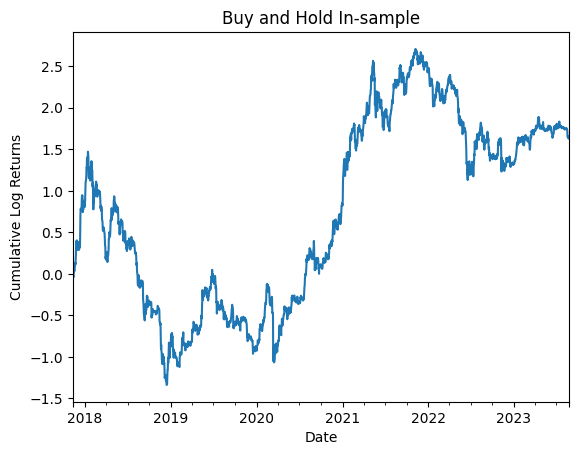

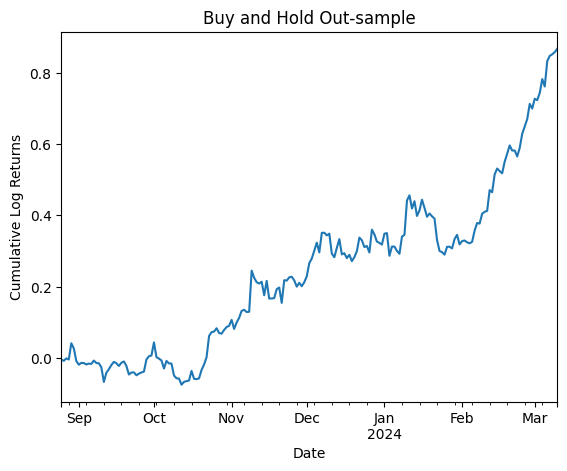

Initial price for training data: 
 320.8840026855469
Estimated final price for training data: 
 1679.2744140624986
Initial final price for testing data: 
 1659.944580078125
Estimated final price for testing data: 
 3952.8762207031236


In [34]:
# Assuming features_sorted and features_test_sorted are already defined and contain the log returns
# Calculate cumulative log returns
bh_out_nn = log_returns_test_nn.cumsum()
bh_in_nn = log_returns_nn.cumsum()

# Convert cumulative log returns to total growth factors
# This step is necessary if you want to translate these sums back to a price scale for interpretation
initial_price_train_nn = train_data_eth[aim].iloc[0]  # adjust based on your actual data
initial_price_test_nn = test_data_eth[aim].iloc[0]    # adjust based on your actual data

final_price_train_nn = initial_price_train_nn * np.exp(bh_in_nn.iloc[-1])
final_price_test_nn = initial_price_test_nn * np.exp(bh_out_nn.iloc[-1])

# Plotting Buy and Hold based on log of differences
bh_in_nn.plot(title='Buy and Hold In-sample', ylabel='Cumulative Log Returns')
plt.show()

bh_out_nn.plot(title='Buy and Hold Out-sample', ylabel='Cumulative Log Returns')
plt.show()
print("Initial price for training data: \n",initial_price_train_nn)
print("Estimated final price for training data: \n",final_price_train_nn)

print("Initial final price for testing data: \n",initial_price_test_nn)
print("Estimated final price for testing data: \n",final_price_test_nn)


Buy and Hold with only pure prices and not the log returns:

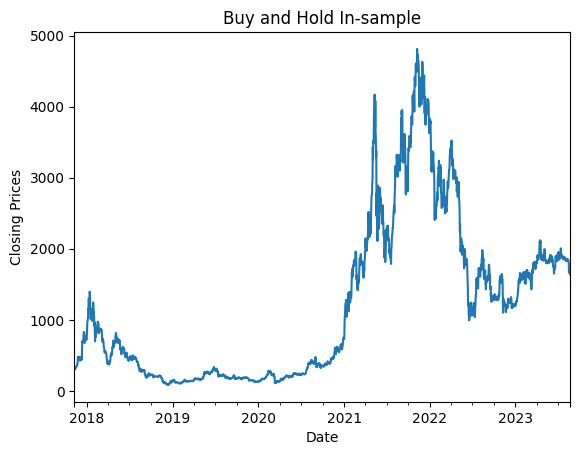

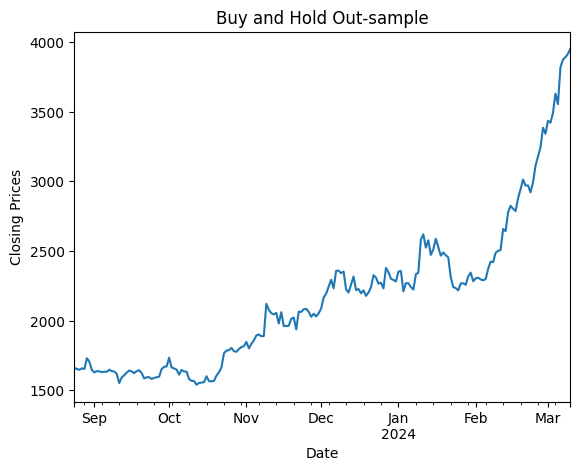

Total return for training period: 423.33%
Total return for testing period: 138.13%


In [35]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming train_data_eth_sorted and test_data_eth_sorted are your sorted DataFrames
# For Buy and Hold, we just need the initial and final prices for the period.

# Training Data
initial_price_train_origignal_price_nn = train_data_eth[aim].iloc[0]  # First price in the dataset
final_price_train_origignal_price_nn = train_data_eth[aim].iloc[-1]  # Last price in the dataset
total_return_train_origignal_price_nn = (final_price_train_origignal_price_nn - initial_price_train_origignal_price_nn) / initial_price_train_origignal_price_nn * 100  # Percentage return

# Test Data
initial_price_test_origignal_price_nn = test_data_eth[aim].iloc[0]
final_price_test_origignal_price_nn = test_data_eth[aim].iloc[-1]
total_return_test_origignal_price_nn = (final_price_test_origignal_price_nn - initial_price_test_origignal_price_nn) / initial_price_test_origignal_price_nn * 100

# Plotting
train_data_eth[aim].plot(title='Buy and Hold In-sample', ylabel='Closing Prices')
plt.show()

test_data_eth[aim].plot(title='Buy and Hold Out-sample', ylabel='Closing Prices')
plt.show()

print("Total return for training period: {:.2f}%".format(total_return_train_origignal_price_nn))
print("Total return for testing period: {:.2f}%".format(total_return_test_origignal_price_nn))


### LPD Absolute Strategy Performance

The strategy involves using the upper and lower quantiles of the absolute values of LPD to decide on market entries and exits. This strategy requires calculating rolling quantiles

In [36]:
lpd_train_df_nn

lag_1     lag_2     lag_3     lag_4     lag_5  \
Date                                                                          
2017-11-16 00:00:00+00:00  0.238832  0.065132  0.048014  0.081639  0.002591   
2017-11-17 00:00:00+00:00 -0.087469 -0.044101 -0.023818 -0.136699 -0.076636   
2017-11-18 00:00:00+00:00  0.154375  0.167627  0.043036 -0.129263  0.138302   
2017-11-19 00:00:00+00:00  0.140503  0.169435  0.052965 -0.020628 -0.006672   
2017-11-20 00:00:00+00:00  0.088648  0.019218  0.138729  0.089496  0.038985   
...                             ...       ...       ...       ...       ...   
2023-08-19 00:00:00+00:00 -0.059998 -0.013876  0.205438  0.036901  0.017335   
2023-08-20 00:00:00+00:00  0.197331  0.122262  0.060304  0.087049 -0.052883   
2023-08-21 00:00:00+00:00  0.089003  0.081236  0.125032  0.079217 -0.074606   
2023-08-22 00:00:00+00:00  0.023947  0.093704  0.101326  0.097558 -0.014540   
2023-08-23 00:00:00+00:00  0.040981  0.062935  0.025822 -0.144704 -0.009340   

                              lag_6  
Date                                 
2017-11-16 00:00:00+00:00  0.001279  
2017-11-17 00:00:00+00:00  0.111243  
2017-11-18 00:00:00+00:00  0.049571  
2017-11-19 00:00:00+00:00 -0.049349  
2017-11-20 00:00:00+00:00 -0.082837  
...                             ...  
2023-08-19 00:00:00+00:00  0.132011  
2023-08-20 00:00:00+00:00  0.046963  
2023-08-21 00:00:00+00:00 -0.033339  
2023-08-22 00:00:00+00:00  0.034122  
2023-08-23 00:00:00+00:00 -0.021583  

[2107 rows x 6 columns]

#### Quantile

In the following diagrams we have a rolling quantiles, that is why the green and red line start one month later

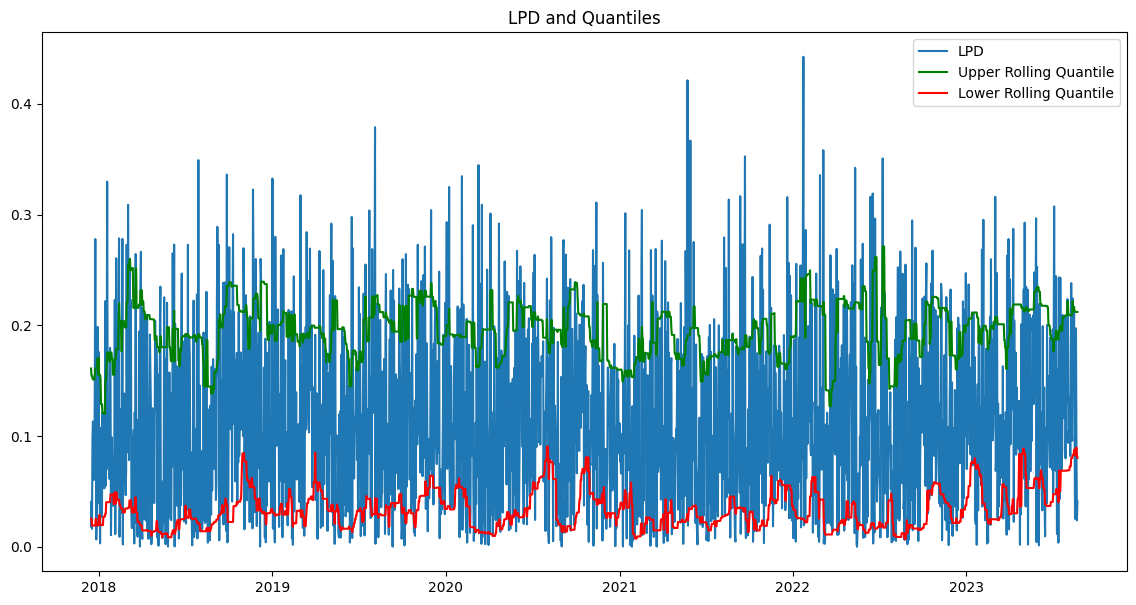

In [37]:
# Example DataFrame of LPDs (assuming LPD_t is your DataFrame of LPDs)
LPD_t_nn = lpd_train_df_nn # Your actual LPD DataFrame goes here

# Use absolute values of LPD
abs_LPD_t_nn = LPD_t_nn.abs()

# Rolling quantiles
roll_quant_up_nn = abs_LPD_t_nn.iloc[:, k_nn -1].rolling(window=length_roll_quantile_nn ).quantile(quantile_select_nn )
roll_quant_low_nn = abs_LPD_t_nn.iloc[:, k_nn -1].rolling(window=length_roll_quantile_nn ).quantile(1 - quantile_select_nn )

# Plotting LPD with upper and lower quantiles
plt.figure(figsize=(14, 7))
plt.plot(abs_LPD_t_nn.iloc[length_roll_quantile_nn -1:,].index, abs_LPD_t_nn.iloc[length_roll_quantile_nn -1:, k_nn -1], label='LPD')
plt.plot(roll_quant_up_nn.index, roll_quant_up_nn, label='Upper Rolling Quantile', color='green')
plt.plot(roll_quant_low_nn.index, roll_quant_low_nn, label='Lower Rolling Quantile', color='red')
plt.legend()
plt.title('LPD and Quantiles')
plt.show()


    Exit the market if the absolute LPD is above the upper quantile or below the lower quantile (signifying high risk).
    Enter (or stay in) the market otherwise.

Out of Sample

In [38]:
lpd_train_df_nn.iloc[-length_roll_quantile_nn:]

lag_1     lag_2     lag_3     lag_4     lag_5  \
Date                                                                          
2023-07-25 00:00:00+00:00  0.148579  0.029814  0.112532  0.015475 -0.086914   
2023-07-26 00:00:00+00:00  0.116088  0.107450  0.094008  0.023756  0.037002   
2023-07-27 00:00:00+00:00  0.133991  0.117830  0.088760  0.011034  0.017332   
2023-07-28 00:00:00+00:00  0.207010 -0.033254  0.097644  0.044084  0.000795   
2023-07-29 00:00:00+00:00  0.079981  0.079016  0.100105  0.017850  0.018870   
2023-07-30 00:00:00+00:00  0.142977  0.083670  0.020220 -0.073218  0.044557   
2023-07-31 00:00:00+00:00  0.200528  0.020232  0.112391  0.043040 -0.065664   
2023-08-01 00:00:00+00:00  0.130509  0.077515  0.043927 -0.057665 -0.071988   
2023-08-02 00:00:00+00:00  0.223764  0.132242 -0.004586 -0.022852  0.047751   
2023-08-03 00:00:00+00:00  0.209359  0.009951  0.109304  0.069363 -0.047518   
2023-08-04 00:00:00+00:00  0.093854  0.100415  0.106797 -0.000716 -0.013114   
2023-08-05 00:00:00+00:00  0.105006  0.141948  0.076787  0.005519  0.071835   
2023-08-06 00:00:00+00:00  0.100211  0.077038  0.102333 -0.022925  0.073644   
2023-08-07 00:00:00+00:00  0.135498  0.075394  0.144637  0.133864 -0.031784   
2023-08-08 00:00:00+00:00  0.082017  0.070275  0.068830 -0.110105 -0.022597   
2023-08-09 00:00:00+00:00  0.178846  0.115694  0.069398  0.017676  0.060178   
2023-08-10 00:00:00+00:00  0.238199  0.031657  0.157873  0.059971  0.023250   
2023-08-11 00:00:00+00:00  0.109745  0.094867  0.054500 -0.061368 -0.090993   
2023-08-12 00:00:00+00:00  0.095809  0.125962  0.077595 -0.073056 -0.064448   
2023-08-13 00:00:00+00:00  0.224256  0.086144  0.104994  0.022718  0.154967   
2023-08-14 00:00:00+00:00  0.217489  0.009115  0.067077  0.020079 -0.042681   
2023-08-15 00:00:00+00:00  0.149432  0.073247  0.039235 -0.059765 -0.052981   
2023-08-16 00:00:00+00:00  0.212634  0.037946  0.122161  0.041333 -0.063458   
2023-08-17 00:00:00+00:00  0.112665  0.027536  0.054742 -0.064162 -0.079154   
2023-08-18 00:00:00+00:00 -0.025329 -0.136966  0.090700  0.084532 -0.022982   
2023-08-19 00:00:00+00:00 -0.059998 -0.013876  0.205438  0.036901  0.017335   
2023-08-20 00:00:00+00:00  0.197331  0.122262  0.060304  0.087049 -0.052883   
2023-08-21 00:00:00+00:00  0.089003  0.081236  0.125032  0.079217 -0.074606   
2023-08-22 00:00:00+00:00  0.023947  0.093704  0.101326  0.097558 -0.014540   
2023-08-23 00:00:00+00:00  0.040981  0.062935  0.025822 -0.144704 -0.009340   

                              lag_6  
Date                                 
2023-07-25 00:00:00+00:00  0.057366  
2023-07-26 00:00:00+00:00  0.139629  
2023-07-27 00:00:00+00:00  0.174853  
2023-07-28 00:00:00+00:00 -0.004601  
2023-07-29 00:00:00+00:00  0.109800  
2023-07-30 00:00:00+00:00  0.026177  
2023-07-31 00:00:00+00:00  0.079689  
2023-08-01 00:00:00+00:00  0.172516  
2023-08-02 00:00:00+00:00  0.098683  
2023-08-03 00:00:00+00:00  0.073013  
2023-08-04 00:00:00+00:00  0.147131  
2023-08-05 00:00:00+00:00  0.024789  
2023-08-06 00:00:00+00:00  0.062195  
2023-08-07 00:00:00+00:00  0.101540  
2023-08-08 00:00:00+00:00  0.058208  
2023-08-09 00:00:00+00:00  0.147110  
2023-08-10 00:00:00+00:00  0.118643  
2023-08-11 00:00:00+00:00  0.147284  
2023-08-12 00:00:00+00:00  0.138173  
2023-08-13 00:00:00+00:00  0.163380  
2023-08-14 00:00:00+00:00  0.150052  
2023-08-15 00:00:00+00:00  0.183575  
2023-08-16 00:00:00+00:00  0.101267  
2023-08-17 00:00:00+00:00  0.081478  
2023-08-18 00:00:00+00:00  0.175831  
2023-08-19 00:00:00+00:00  0.132011  
2023-08-20 00:00:00+00:00  0.046963  
2023-08-21 00:00:00+00:00 -0.033339  
2023-08-22 00:00:00+00:00  0.034122  
2023-08-23 00:00:00+00:00 -0.021583

In [39]:
LPD_t_test_nn = lpd_test_df_nn # Your actual LPD DataFrame goes here

# Use absolute values of LPD
abs_LPD_t_test_nn = LPD_t_test_nn.abs()

# Extend test data by last month of train data
last_month_train_lpd = LPD_t_nn.iloc[-length_roll_quantile_nn:]
LPD_t_test_nn = pd.concat([last_month_train_lpd, LPD_t_test_nn])
abs_LPD_t_test_nn=LPD_t_test_nn.abs()
print(LPD_t_test_nn)


                              lag_1     lag_2     lag_3     lag_4     lag_5  \
Date                                                                          
2023-07-25 00:00:00+00:00  0.148579  0.029814  0.112532  0.015475 -0.086914   
2023-07-26 00:00:00+00:00  0.116088  0.107450  0.094008  0.023756  0.037002   
2023-07-27 00:00:00+00:00  0.133991  0.117830  0.088760  0.011034  0.017332   
2023-07-28 00:00:00+00:00  0.207010 -0.033254  0.097644  0.044084  0.000795   
2023-07-29 00:00:00+00:00  0.079981  0.079016  0.100105  0.017850  0.018870   
...                             ...       ...       ...       ...       ...   
2024-03-06 00:00:00+00:00  0.215981  0.086958  0.186306  0.070916  0.023082   
2024-03-07 00:00:00+00:00  0.053095  0.057476  0.009014 -0.105674  0.121109   
2024-03-08 00:00:00+00:00  0.108165  0.185100 -0.079452 -0.144169 -0.016490   
2024-03-09 00:00:00+00:00  0.087324  0.145746  0.016889 -0.045253  0.079140   
2024-03-10 00:00:00+00:00  0.051640  0.061254  0.026

In [40]:
abs_LPD_t_test_nn

lag_1     lag_2     lag_3     lag_4     lag_5  \
Date                                                                          
2023-07-25 00:00:00+00:00  0.148579  0.029814  0.112532  0.015475  0.086914   
2023-07-26 00:00:00+00:00  0.116088  0.107450  0.094008  0.023756  0.037002   
2023-07-27 00:00:00+00:00  0.133991  0.117830  0.088760  0.011034  0.017332   
2023-07-28 00:00:00+00:00  0.207010  0.033254  0.097644  0.044084  0.000795   
2023-07-29 00:00:00+00:00  0.079981  0.079016  0.100105  0.017850  0.018870   
...                             ...       ...       ...       ...       ...   
2024-03-06 00:00:00+00:00  0.215981  0.086958  0.186306  0.070916  0.023082   
2024-03-07 00:00:00+00:00  0.053095  0.057476  0.009014  0.105674  0.121109   
2024-03-08 00:00:00+00:00  0.108165  0.185100  0.079452  0.144169  0.016490   
2024-03-09 00:00:00+00:00  0.087324  0.145746  0.016889  0.045253  0.079140   
2024-03-10 00:00:00+00:00  0.051640  0.061254  0.026019  0.169989  0.002834   

                              lag_6  
Date                                 
2023-07-25 00:00:00+00:00  0.057366  
2023-07-26 00:00:00+00:00  0.139629  
2023-07-27 00:00:00+00:00  0.174853  
2023-07-28 00:00:00+00:00  0.004601  
2023-07-29 00:00:00+00:00  0.109800  
...                             ...  
2024-03-06 00:00:00+00:00  0.116496  
2024-03-07 00:00:00+00:00  0.066414  
2024-03-08 00:00:00+00:00  0.060094  
2024-03-09 00:00:00+00:00  0.034473  
2024-03-10 00:00:00+00:00  0.004115  

[223 rows x 6 columns]

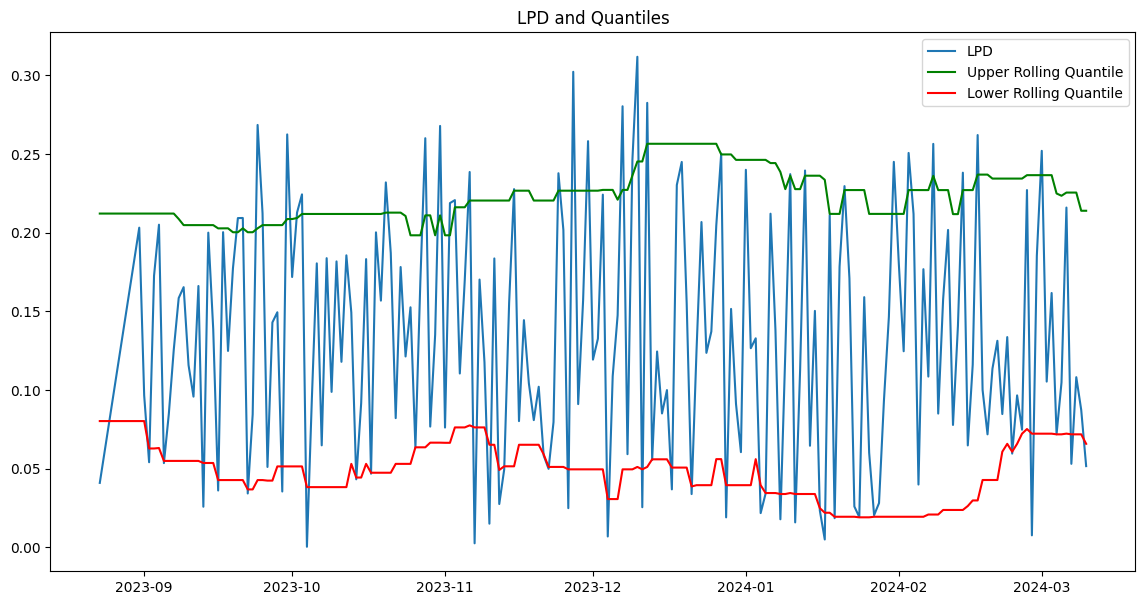

In [41]:
# Rolling quantiles
roll_quant_up_test_nn = abs_LPD_t_test_nn.iloc[:, k_nn-1].rolling(window=length_roll_quantile_nn).quantile(quantile_select_nn)
roll_quant_low_test_nn = abs_LPD_t_test_nn.iloc[:, k_nn-1].rolling(window=length_roll_quantile_nn).quantile(1 - quantile_select_nn)

# Plotting LPD with upper and lower quantiles
plt.figure(figsize=(14, 7))
plt.plot(abs_LPD_t_test_nn.iloc[length_roll_quantile_nn-1:,].index, abs_LPD_t_test_nn.iloc[length_roll_quantile_nn-1:, k_nn-1], label='LPD')
plt.plot(roll_quant_up_test_nn.index, roll_quant_up_test_nn, label='Upper Rolling Quantile', color='green')
plt.plot(roll_quant_low_test_nn.index, roll_quant_low_test_nn, label='Lower Rolling Quantile', color='red')
plt.legend()
plt.title('LPD and Quantiles')
plt.show()


In [42]:
roll_quant_up_test_nn

Date
2023-07-25 00:00:00+00:00         NaN
2023-07-26 00:00:00+00:00         NaN
2023-07-27 00:00:00+00:00         NaN
2023-07-28 00:00:00+00:00         NaN
2023-07-29 00:00:00+00:00         NaN
                               ...   
2024-03-06 00:00:00+00:00    0.225515
2024-03-07 00:00:00+00:00    0.225515
2024-03-08 00:00:00+00:00    0.225515
2024-03-09 00:00:00+00:00    0.213950
2024-03-10 00:00:00+00:00    0.213950
Name: lag_1, Length: 223, dtype: float64

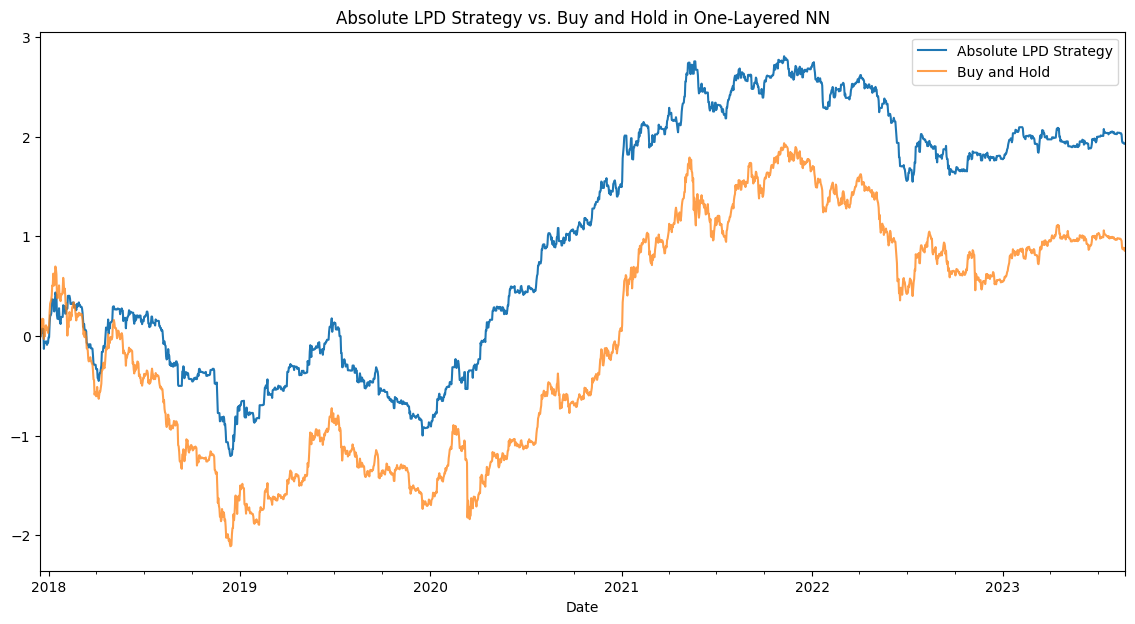

In [43]:
def simulate_strategy(abs_lpd_series, roll_quant_up, roll_quant_low, daily_returns):
    # Determine positions: 1 for holding the asset, 0 for exiting the market
    positions = ((abs_lpd_series <= roll_quant_up) & (abs_lpd_series >= roll_quant_low)).astype(int)
    # Calculate daily strategy returns by multiplying positions with daily returns
    strategy_returns = positions.shift(1) * daily_returns  # Shift positions to reflect action taken at the end of the day
    cumulative_returns = strategy_returns.cumsum()
    return cumulative_returns


#In sample
# Simulate the strategy
daily_returns_abs_in_sample_nn  = features_nn['current_return'].iloc[length_roll_quantile_nn-1:]
cumulative_returns_abs_in_sample_nn = simulate_strategy(abs_LPD_t_nn.iloc[:,k_nn-1].iloc[length_roll_quantile_nn-1:], roll_quant_up_nn.iloc[length_roll_quantile_nn-1:], roll_quant_low_nn.iloc[length_roll_quantile_nn-1:], daily_returns_abs_in_sample_nn)

# Plot the cumulative returns of the strategy against buy-and-hold
plt.figure(figsize=(14, 7))
cumulative_returns_abs_in_sample_nn.plot(label='Absolute LPD Strategy', legend=True)
daily_returns_abs_in_sample_nn.cumsum().plot(label='Buy and Hold', legend=True, alpha=0.75)
plt.title('Absolute LPD Strategy vs. Buy and Hold in One-Layered NN')
plt.show()


#### IN Sample Sharpe Ratio

In [44]:
def calculate_sharpe_ratio(daily_returns, risk_free_rate=0):
    """
    Calculate the Sharpe Ratio for a series of daily returns.
    Args:
        daily_returns (pd.Series): Daily returns of the strategy.
        risk_free_rate (float): Daily risk-free rate, default is 0.
    Returns:
        float: The Sharpe Ratio.
    """
    # Adjust returns for risk-free rate
    excess_returns = daily_returns - risk_free_rate

    # Annualize the returns and standard deviation
    annualized_return = excess_returns.mean() * year_length
    annualized_std = excess_returns.std() * np.sqrt(year_length)

    return annualized_return / annualized_std

# Calculate Sharpe Ratios
sharpe_ratio_buy_and_hold_abs_in_sample  = calculate_sharpe_ratio(daily_returns_abs_in_sample_nn)
sharpe_ratio_abs_strategy_abs_in_sample  = calculate_sharpe_ratio(cumulative_returns_abs_in_sample_nn.diff())

# Print Sharpe Ratios
print(f"Sharpe Ratio - Buy and Hold: {sharpe_ratio_buy_and_hold_abs_in_sample :.2f}")
print(f"Sharpe Ratio - Absolute LPD Strategy: {sharpe_ratio_abs_strategy_abs_in_sample:.2f}")


Sharpe Ratio - Buy and Hold: 0.17
Sharpe Ratio - Absolute LPD Strategy: 0.46


In [45]:
abs_LPD_t_test_nn

lag_1     lag_2     lag_3     lag_4     lag_5  \
Date                                                                          
2023-07-25 00:00:00+00:00  0.148579  0.029814  0.112532  0.015475  0.086914   
2023-07-26 00:00:00+00:00  0.116088  0.107450  0.094008  0.023756  0.037002   
2023-07-27 00:00:00+00:00  0.133991  0.117830  0.088760  0.011034  0.017332   
2023-07-28 00:00:00+00:00  0.207010  0.033254  0.097644  0.044084  0.000795   
2023-07-29 00:00:00+00:00  0.079981  0.079016  0.100105  0.017850  0.018870   
...                             ...       ...       ...       ...       ...   
2024-03-06 00:00:00+00:00  0.215981  0.086958  0.186306  0.070916  0.023082   
2024-03-07 00:00:00+00:00  0.053095  0.057476  0.009014  0.105674  0.121109   
2024-03-08 00:00:00+00:00  0.108165  0.185100  0.079452  0.144169  0.016490   
2024-03-09 00:00:00+00:00  0.087324  0.145746  0.016889  0.045253  0.079140   
2024-03-10 00:00:00+00:00  0.051640  0.061254  0.026019  0.169989  0.002834   

                              lag_6  
Date                                 
2023-07-25 00:00:00+00:00  0.057366  
2023-07-26 00:00:00+00:00  0.139629  
2023-07-27 00:00:00+00:00  0.174853  
2023-07-28 00:00:00+00:00  0.004601  
2023-07-29 00:00:00+00:00  0.109800  
...                             ...  
2024-03-06 00:00:00+00:00  0.116496  
2024-03-07 00:00:00+00:00  0.066414  
2024-03-08 00:00:00+00:00  0.060094  
2024-03-09 00:00:00+00:00  0.034473  
2024-03-10 00:00:00+00:00  0.004115  

[223 rows x 6 columns]

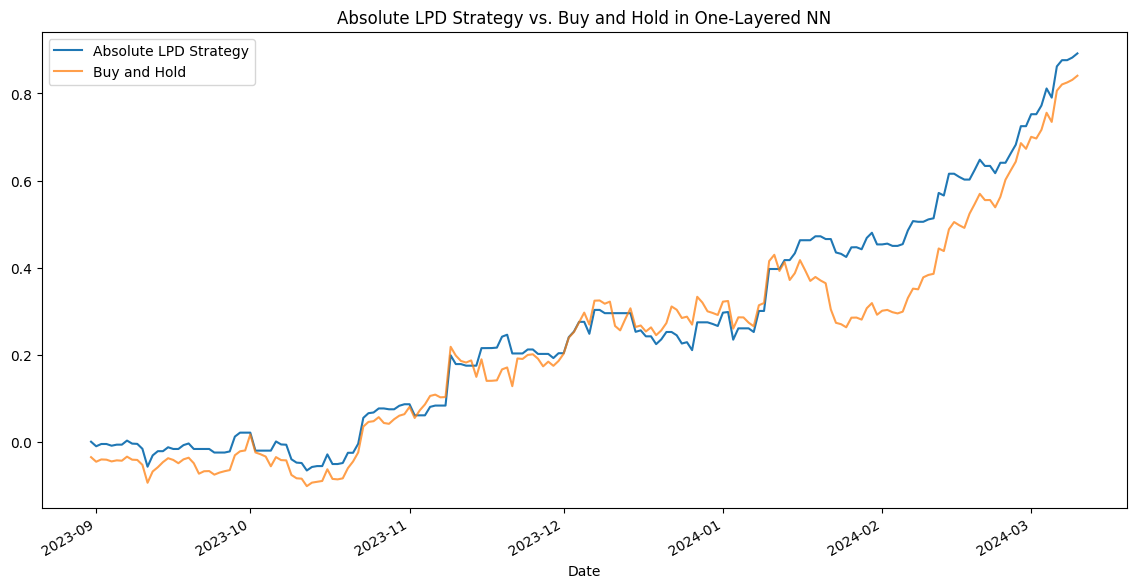

In [46]:
# Out sample
# Simulate the strategy
daily_returns_abs_out_sample = features_test_nn['current_return']
cumulative_returns_abs_out_sample = simulate_strategy(abs_LPD_t_test_nn.iloc[:,k_nn-1].iloc[length_roll_quantile_nn-1:], roll_quant_up_test_nn.iloc[length_roll_quantile_nn-1:], roll_quant_low_test_nn.iloc[length_roll_quantile_nn-1:], daily_returns_abs_out_sample)

# Plot the cumulative returns of the strategy against buy-and-hold
plt.figure(figsize=(14, 7))
cumulative_returns_abs_out_sample.plot(label='Absolute LPD Strategy', legend=True)
daily_returns_abs_out_sample.cumsum().plot(label='Buy and Hold', legend=True, alpha=0.75)
plt.title('Absolute LPD Strategy vs. Buy and Hold in One-Layered NN')
plt.show()

In [47]:
daily_returns_abs_out_sample

Date
2023-08-31 00:00:00+00:00   -0.035502
2023-09-01 00:00:00+00:00   -0.010475
2023-09-02 00:00:00+00:00    0.005227
2023-09-03 00:00:00+00:00   -0.000555
2023-09-04 00:00:00+00:00   -0.003958
                               ...   
2024-03-06 00:00:00+00:00    0.071703
2024-03-07 00:00:00+00:00    0.014329
2024-03-08 00:00:00+00:00    0.004562
2024-03-09 00:00:00+00:00    0.005983
2024-03-10 00:00:00+00:00    0.009521
Name: current_return, Length: 193, dtype: float64

We don't predict on first day

In [48]:
cumulative_returns_abs_out_sample

Date
2023-08-23 00:00:00+00:00         NaN
2023-08-31 00:00:00+00:00    0.000000
2023-09-01 00:00:00+00:00   -0.010475
2023-09-02 00:00:00+00:00   -0.005248
2023-09-03 00:00:00+00:00   -0.005248
                               ...   
2024-03-06 00:00:00+00:00    0.862207
2024-03-07 00:00:00+00:00    0.876536
2024-03-08 00:00:00+00:00    0.876536
2024-03-09 00:00:00+00:00    0.882520
2024-03-10 00:00:00+00:00    0.892041
Length: 194, dtype: float64

In [49]:
daily_returns_abs_out_sample.cumsum()

Date
2023-08-31 00:00:00+00:00   -0.035502
2023-09-01 00:00:00+00:00   -0.045977
2023-09-02 00:00:00+00:00   -0.040750
2023-09-03 00:00:00+00:00   -0.041305
2023-09-04 00:00:00+00:00   -0.045262
                               ...   
2024-03-06 00:00:00+00:00    0.806417
2024-03-07 00:00:00+00:00    0.820746
2024-03-08 00:00:00+00:00    0.825308
2024-03-09 00:00:00+00:00    0.831291
2024-03-10 00:00:00+00:00    0.840813
Name: current_return, Length: 193, dtype: float64

In [50]:
LPD_t_test_nn

lag_1     lag_2     lag_3     lag_4     lag_5  \
Date                                                                          
2023-07-25 00:00:00+00:00  0.148579  0.029814  0.112532  0.015475 -0.086914   
2023-07-26 00:00:00+00:00  0.116088  0.107450  0.094008  0.023756  0.037002   
2023-07-27 00:00:00+00:00  0.133991  0.117830  0.088760  0.011034  0.017332   
2023-07-28 00:00:00+00:00  0.207010 -0.033254  0.097644  0.044084  0.000795   
2023-07-29 00:00:00+00:00  0.079981  0.079016  0.100105  0.017850  0.018870   
...                             ...       ...       ...       ...       ...   
2024-03-06 00:00:00+00:00  0.215981  0.086958  0.186306  0.070916  0.023082   
2024-03-07 00:00:00+00:00  0.053095  0.057476  0.009014 -0.105674  0.121109   
2024-03-08 00:00:00+00:00  0.108165  0.185100 -0.079452 -0.144169 -0.016490   
2024-03-09 00:00:00+00:00  0.087324  0.145746  0.016889 -0.045253  0.079140   
2024-03-10 00:00:00+00:00  0.051640  0.061254  0.026019 -0.169989 -0.002834   

                              lag_6  
Date                                 
2023-07-25 00:00:00+00:00  0.057366  
2023-07-26 00:00:00+00:00  0.139629  
2023-07-27 00:00:00+00:00  0.174853  
2023-07-28 00:00:00+00:00 -0.004601  
2023-07-29 00:00:00+00:00  0.109800  
...                             ...  
2024-03-06 00:00:00+00:00  0.116496  
2024-03-07 00:00:00+00:00  0.066414  
2024-03-08 00:00:00+00:00 -0.060094  
2024-03-09 00:00:00+00:00  0.034473  
2024-03-10 00:00:00+00:00  0.004115  

[223 rows x 6 columns]

#### Out of sample Sharpe-Ratio comparison

In [51]:
def calculate_sharpe_ratio(daily_returns, risk_free_rate=0):
    """
    Calculate the Sharpe Ratio for a series of daily returns.
    Args:
        daily_returns (pd.Series): Daily returns of the strategy.
        risk_free_rate (float): Daily risk-free rate, default is 0.
    Returns:
        float: The Sharpe Ratio.
    """
    # Adjust returns for risk-free rate
    excess_returns = daily_returns - risk_free_rate

    # Annualize the returns and standard deviation
    annualized_return = excess_returns.mean() * year_length
    annualized_std = excess_returns.std() * np.sqrt(year_length)

    return annualized_return / annualized_std

# Calculate Sharpe Ratios
sharpe_ratio_buy_and_hold_abs_out_sample = calculate_sharpe_ratio(daily_returns_abs_out_sample)
sharpe_ratio_abs_strategy_abs_out_sample = calculate_sharpe_ratio(cumulative_returns_abs_out_sample.diff()) # we calculate the diff, because the cumulative can't be used for sharpe ratio

# Print Sharpe Ratios
print(f"Sharpe Ratio - Buy and Hold: {sharpe_ratio_buy_and_hold_abs_out_sample:.2f}")
print(f"Sharpe Ratio - Absolute LPD Strategy: {sharpe_ratio_abs_strategy_abs_out_sample:.2f}")


Sharpe Ratio - Buy and Hold: 3.33
Sharpe Ratio - Absolute LPD Strategy: 4.18


Out of sample real Prices

### Random networks

In [52]:
def random_lpd_list(x_train_eth_nn,y_train_eth_nn,x_test_eth_nn,y_test_eth_nn):
  random_lpd_list = []
  random_lpd_list_test=[]
  num_nets = num_nets_nn  # Number of random networks to train

  for i in range(num_nets):
      # Set the random seed for reproducibility
      np.random.seed(i)
      tf.random.set_seed(i)

      model_eth_nn = create_model(x_train_eth_nn.shape[1], linear_output=linear_output_nn)
      model_eth_nn.summary()
      modelfit_eth_nn = model_eth_nn.fit(
          x_train_eth_nn, y_train_eth_nn, validation_data=(x_test_eth_nn, y_test_eth_nn), epochs=epochs_nn, batch_size=batch_size_nn, verbose=1, shuffle=shuffle_nn,  callbacks=[early_stopping] )

      # Assuming you have a function to create, train a model, and compute LPD named `create_train_compute_lpd`
      lpd_df = compute_lpd_with_dates(model_eth_nn, x_train_eth_nn, linear_output=linear_output_nn)
      # use the same model for out of sample lpd
      lpd_df_test = compute_lpd_with_dates(model_eth_nn, x_test_eth_nn, linear_output=linear_output_nn)

      random_lpd_list.append(lpd_df)
      random_lpd_list_test.append(lpd_df_test)
  return random_lpd_list,random_lpd_list_test


In [53]:
random_lpd_list_nn,random_lpd_list_test_nn=random_lpd_list(x_train_eth_nn,y_train_eth_nn,x_test_eth_nn,y_test_eth_nn)

# Concatenate all LPD DataFrames along a new dimension
all_lpd_stack_random_nn = np.dstack([df.values for df in random_lpd_list_nn])  # Shape: [num_samples, num_features, num_models]
all_lpd_stack_test_random_nn = np.dstack([df.values for df in random_lpd_list_test_nn])  # Shape: [num_samples, num_features, num_models]

# Compute mean and standard deviation across the models (last dimension)
mean_lpd_random_nn = np.mean(all_lpd_stack_random_nn, axis=2)
std_lpd_random_nn = np.std(all_lpd_stack_random_nn, axis=2)

# Convert mean and STD back to DataFrame for easy plotting
mean_lpd_df_random_nn = pd.DataFrame(mean_lpd_random_nn, index=random_lpd_list_nn[0].index, columns=random_lpd_list_nn[0].columns)
std_lpd_df_random_nn = pd.DataFrame(std_lpd_random_nn, index=random_lpd_list_nn[0].index, columns=random_lpd_list_nn[0].columns)



# Compute mean and standard deviation across the models (last dimension)
mean_lpd_test_random_nn = np.mean(all_lpd_stack_test_random_nn, axis=2)
std_lpd_test_random_nn = np.std(all_lpd_stack_test_random_nn, axis=2)

# Convert mean and STD back to DataFrame for easy plotting
mean_lpd_df_test_random_nn = pd.DataFrame(mean_lpd_test_random_nn, index=random_lpd_list_test_nn[0].index, columns=random_lpd_list_test_nn[0].columns)
std_lpd_df_test_random_nn = pd.DataFrame(std_lpd_test_random_nn, index=random_lpd_list_test_nn[0].index, columns=random_lpd_list_test_nn[0].columns)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 64)                448       
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 513 (2.00 KB)
Trainable params: 513 (2.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/20
66/66 [==============================] - 1s 5ms/step - loss: 0.0025 - val_loss: 6.5318e-04
Epoch 2/20
66/66 [==============================] - 0s 2ms/step - loss: 0.0024 - val_loss: 7.0864e-04
Epoch 3/20
66/66 [==============================] - 0s 3ms/step - loss: 0.0024 - val_loss: 6.5549e-04
Epoch 4/20
66/66 [==============================] - 0s 3ms/step - loss: 0.0023 - val_loss: 7.1185e-04
Epoch 5/20
6

In sample

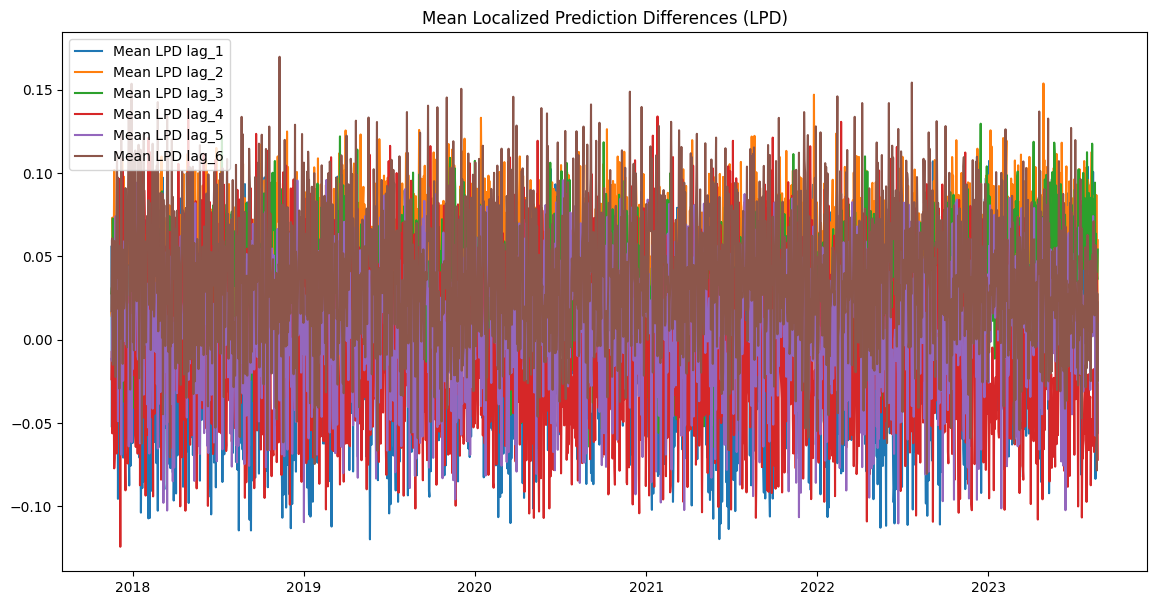

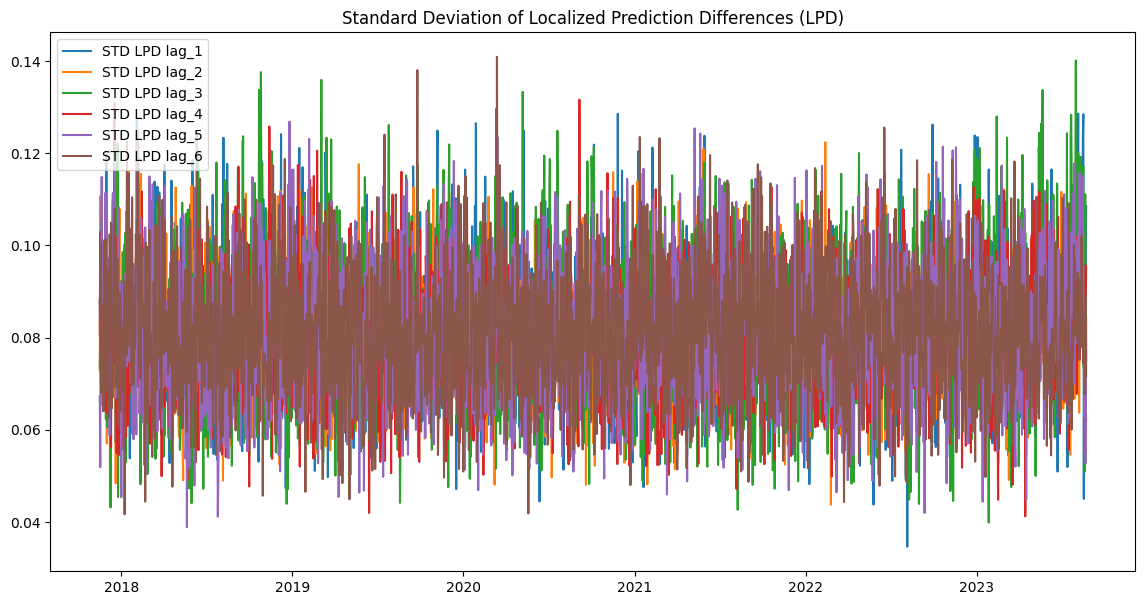

In [54]:
# Plot Mean LPD
plt.figure(figsize=(14, 7))
for col in mean_lpd_df_random_nn.columns:
    plt.plot(mean_lpd_df_random_nn.index, mean_lpd_df_random_nn[col], label=f'Mean LPD {col}')
plt.title('Mean Localized Prediction Differences (LPD)')
plt.legend()
plt.show()

# Plot STD LPD
plt.figure(figsize=(14, 7))
for col in std_lpd_df_random_nn.columns:
    plt.plot(std_lpd_df_random_nn.index, std_lpd_df_random_nn[col], label=f'STD LPD {col}')
plt.title('Standard Deviation of Localized Prediction Differences (LPD)')
plt.legend()
plt.show()


Out of sample

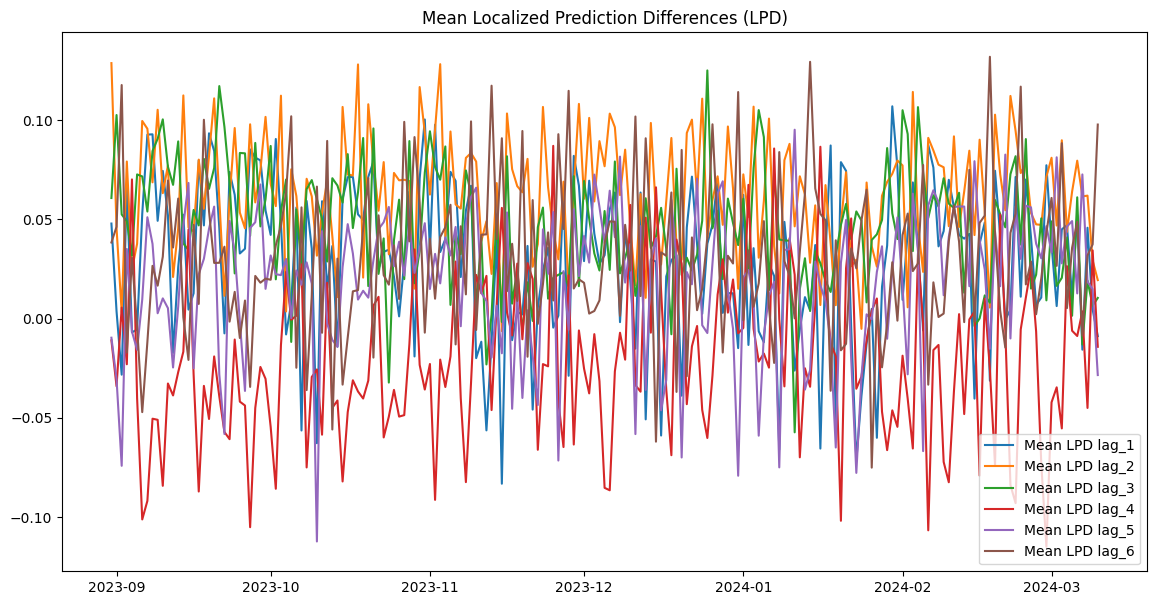

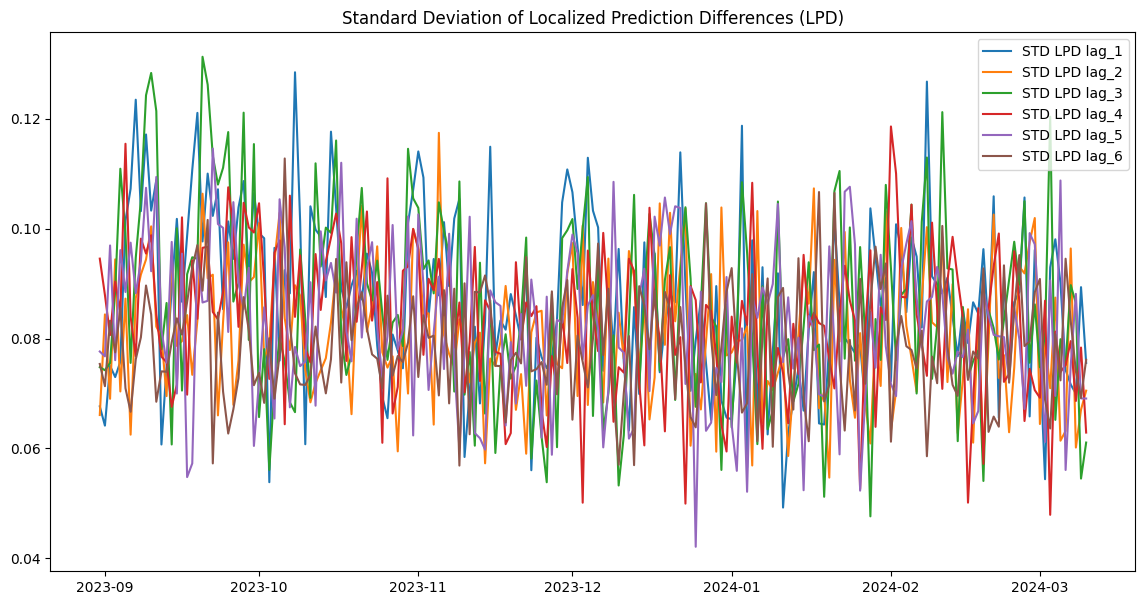

In [55]:
# Plot Mean LPD
plt.figure(figsize=(14, 7))
for col in mean_lpd_df_test_random_nn.columns:
    plt.plot(mean_lpd_df_test_random_nn.index, mean_lpd_df_test_random_nn[col], label=f'Mean LPD {col}')
plt.title('Mean Localized Prediction Differences (LPD)')
plt.legend()
plt.show()

# Plot STD LPD
plt.figure(figsize=(14, 7))
for col in std_lpd_df_test_random_nn.columns:
    plt.plot(std_lpd_df_test_random_nn.index, std_lpd_df_test_random_nn[col], label=f'STD LPD {col}')
plt.title('Standard Deviation of Localized Prediction Differences (LPD)')
plt.legend()
plt.show()


### LPD variance Strategy

In [56]:
# Compute variance across the models (last dimension)
LPD_var_nn = np.var(all_lpd_stack_random_nn, axis=2)

# Assuming the index from your LPD dataframes can represent the dates or sequence
LPD_var_df_nn = pd.DataFrame(LPD_var_nn, index=random_lpd_list_nn[0].index, columns=random_lpd_list_nn[0].columns)


out of sample

In [57]:
# Compute variance across the models (last dimension)
LPD_var_test = np.var(all_lpd_stack_test_random_nn, axis=2)

# Assuming the index from your LPD dataframes can represent the dates or sequence
LPD_var_df_test = pd.DataFrame(LPD_var_test, index=random_lpd_list_test_nn[0].index, columns=random_lpd_list_test_nn[0].columns)


In [58]:
LPD_var_nn

array([[0.00774235, 0.00528545, 0.00536197, 0.00651344, 0.00451284,
        0.0077658 ],
       [0.00587693, 0.01224474, 0.00656089, 0.01059538, 0.00269406,
        0.00721314],
       [0.00951164, 0.00492256, 0.00825766, 0.00536433, 0.00911318,
        0.010138  ],
       ...,
       [0.00731372, 0.00469599, 0.0123441 , 0.0030515 , 0.0043451 ,
        0.00490433],
       [0.0075228 , 0.00429456, 0.00688817, 0.00915606, 0.0027855 ,
        0.00793936],
       [0.01177333, 0.00383802, 0.00916575, 0.00562849, 0.00709728,
        0.00513561]], dtype=float32)

In [59]:
LPD_var_df_nn

lag_1     lag_2     lag_3     lag_4     lag_5  \
Date                                                                          
2017-11-16 00:00:00+00:00  0.007742  0.005285  0.005362  0.006513  0.004513   
2017-11-17 00:00:00+00:00  0.005877  0.012245  0.006561  0.010595  0.002694   
2017-11-18 00:00:00+00:00  0.009512  0.004923  0.008258  0.005364  0.009113   
2017-11-19 00:00:00+00:00  0.009670  0.004294  0.007050  0.007079  0.007299   
2017-11-20 00:00:00+00:00  0.005143  0.005380  0.011032  0.005515  0.013194   
...                             ...       ...       ...       ...       ...   
2023-08-19 00:00:00+00:00  0.007469  0.003952  0.011238  0.007023  0.004784   
2023-08-20 00:00:00+00:00  0.004616  0.004996  0.002593  0.006159  0.005833   
2023-08-21 00:00:00+00:00  0.007314  0.004696  0.012344  0.003052  0.004345   
2023-08-22 00:00:00+00:00  0.007523  0.004295  0.006888  0.009156  0.002786   
2023-08-23 00:00:00+00:00  0.011773  0.003838  0.009166  0.005628  0.007097   

                              lag_6  
Date                                 
2017-11-16 00:00:00+00:00  0.007766  
2017-11-17 00:00:00+00:00  0.007213  
2017-11-18 00:00:00+00:00  0.010138  
2017-11-19 00:00:00+00:00  0.004633  
2017-11-20 00:00:00+00:00  0.007464  
...                             ...  
2023-08-19 00:00:00+00:00  0.005977  
2023-08-20 00:00:00+00:00  0.004584  
2023-08-21 00:00:00+00:00  0.004904  
2023-08-22 00:00:00+00:00  0.007939  
2023-08-23 00:00:00+00:00  0.005136  

[2107 rows x 6 columns]

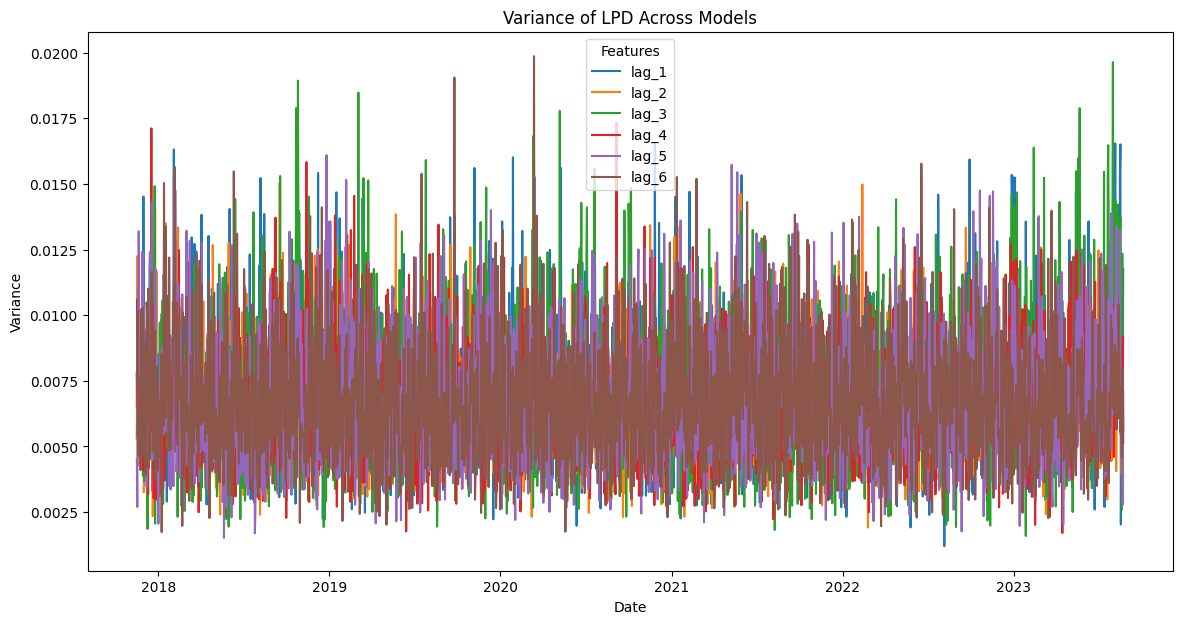

In [60]:
plt.figure(figsize=(14, 7))
for column in LPD_var_df_nn.columns:
    plt.plot(LPD_var_df_nn.index, LPD_var_df_nn[column], label=column)
plt.legend(title="Features")
plt.title("Variance of LPD Across Models")
plt.xlabel("Date")
plt.ylabel("Variance")
plt.show()


Out of sample

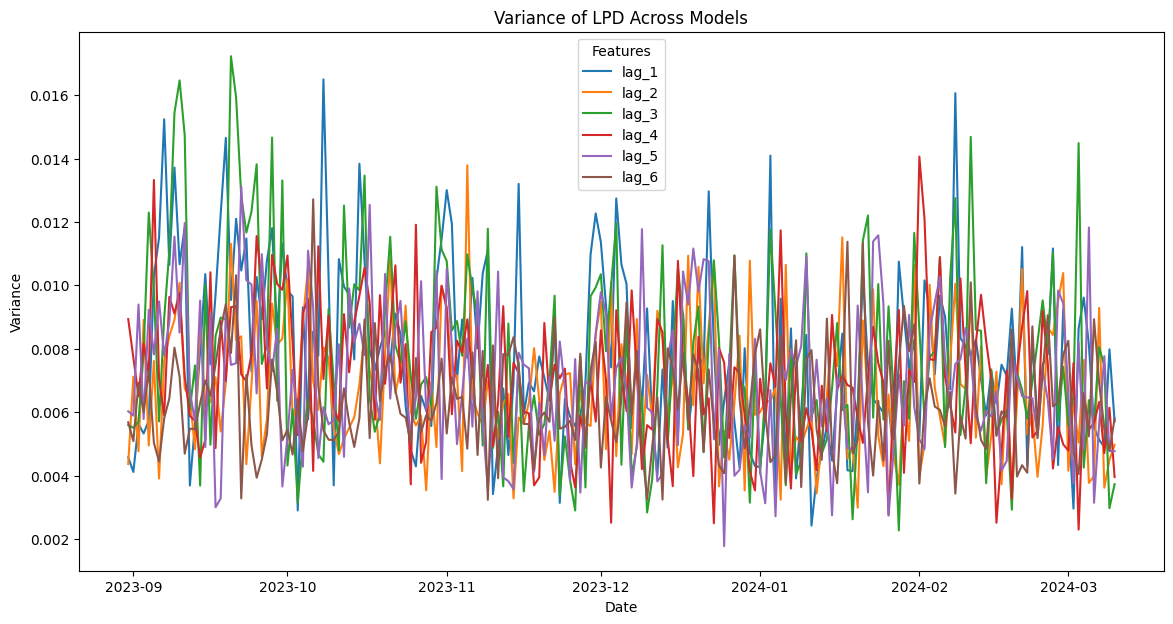

In [61]:
plt.figure(figsize=(14, 7))
for column in LPD_var_df_test.columns:
    plt.plot(LPD_var_df_test.index, LPD_var_df_test[column], label=column)
plt.legend(title="Features")
plt.title("Variance of LPD Across Models")
plt.xlabel("Date")
plt.ylabel("Variance")
plt.show()


#### Strategy Implementation

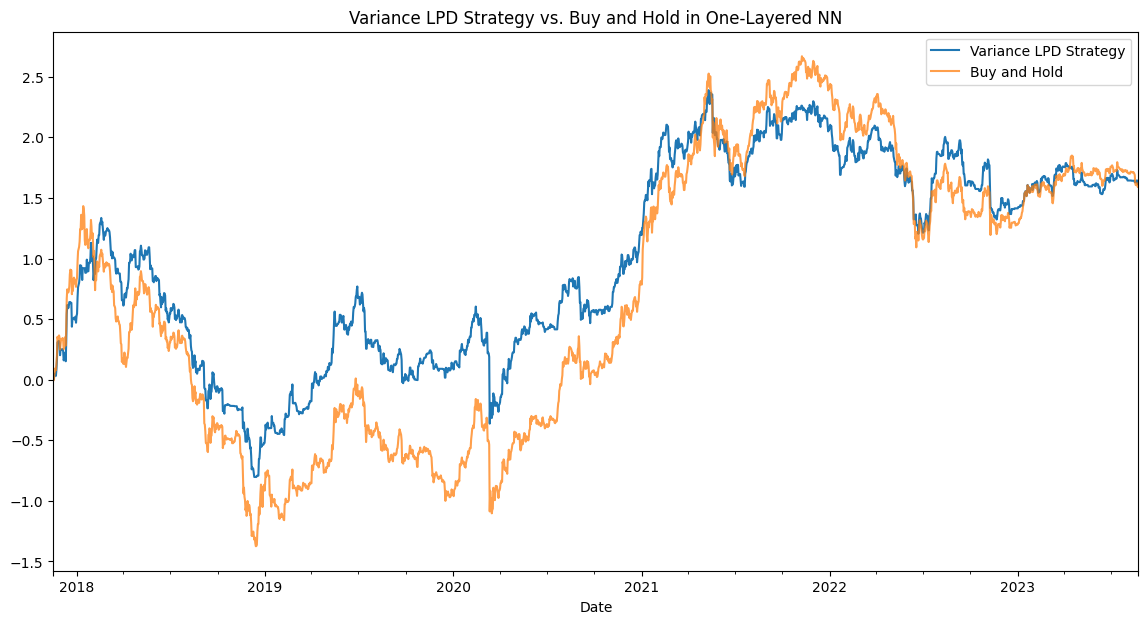

In [62]:
def simulate_variance_strategy(daily_returns, LPD_variance, threshold):
    """
    Simulate a trading strategy based on LPD variance.
    Args:
        daily_returns (pd.Series): The daily returns of the asset.
        LPD_variance (pd.Series): The variance of LPD for a specific feature.
        threshold (float): The variance threshold for deciding market entry/exit.
    Returns:
        pd.Series: The cumulative returns of the strategy.
    """
    # Market position: 1 for in-market, 0 for out-of-market
    position = (LPD_variance < threshold).astype(int)
    strategy_returns = position.shift(1) * daily_returns  # Shift positions for real trading scenario
    cumulative_returns = strategy_returns.cumsum()
    return cumulative_returns

# Example usage with 'lag_1' variance and an arbitrary threshold
variance_threshold_nn = LPD_var_df_nn.iloc[:,k_nn-1].quantile(0.75)  # Using the 75th percentile as threshold
cumulative_returns_var_strategy_nn = simulate_variance_strategy(
    daily_returns=features_nn['current_return'],
    LPD_variance=LPD_var_df_nn.iloc[:,k_nn-1],
    threshold=variance_threshold_nn
)

# Plotting the strategy returns against buy-and-hold
plt.figure(figsize=(14, 7))
cumulative_returns_var_strategy_nn.plot(label='Variance LPD Strategy', legend=True)
features_nn['current_return'].cumsum().plot(label='Buy and Hold', legend=True, alpha=0.75)
plt.title('Variance LPD Strategy vs. Buy and Hold in One-Layered NN')
plt.show()


Key Notes:

The risk_free_rate is set to 0 for simplicity. If you have a specific risk-free rate in mind (e.g., the yield on a 3-month Treasury bill), you can adjust the risk_free_rate parameter accordingly.
The function cumulative_returns_var_strategy.diff() calculates the daily returns from the cumulative returns of the variance-based strategy for the Sharpe Ratio calculation.
The returns and standard deviation are annualized by assuming there are 252 trading days in a year, which is standard practice.

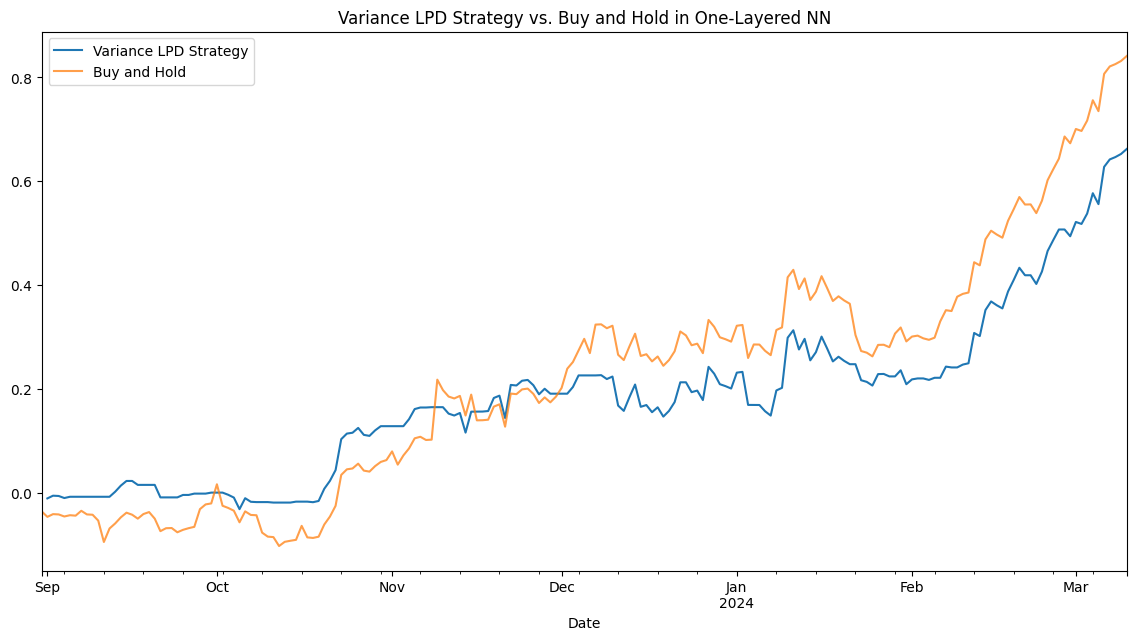

In [63]:
# Example usage with 'lag_1' variance and an arbitrary threshold
variance_threshold_test_nn = LPD_var_df_test.iloc[:,k_nn-1].quantile(0.75)  # Using the 75th percentile as threshold
cumulative_returns_var_strategy_test_nn = simulate_variance_strategy(
    daily_returns=features_test_nn['current_return'],
    LPD_variance=LPD_var_df_test['lag_1'],
    threshold=variance_threshold_test_nn
)

# Plotting the strategy returns against buy-and-hold
plt.figure(figsize=(14, 7))
cumulative_returns_var_strategy_test_nn.plot(label='Variance LPD Strategy', legend=True)
features_test_nn['current_return'].cumsum().plot(label='Buy and Hold', legend=True, alpha=0.75)
plt.title('Variance LPD Strategy vs. Buy and Hold in One-Layered NN')
plt.show()


#### In sample sharpe Ratio

In [64]:
def calculate_sharpe_ratio(daily_returns, risk_free_rate=0):
    """
    Calculate the Sharpe Ratio for a series of daily returns.
    Args:
        daily_returns (pd.Series): Daily returns of the strategy.
        risk_free_rate (float): Daily risk-free rate, default is 0.
    Returns:
        float: The Sharpe Ratio.
    """
    # Adjust returns for risk-free rate
    excess_returns = daily_returns - risk_free_rate

    # Annualize the returns and standard deviation
    annualized_return = excess_returns.mean() * year_length
    annualized_std = excess_returns.std() * np.sqrt(year_length)

    return annualized_return / annualized_std

# Calculate Sharpe Ratios
sharpe_ratio_buy_and_hold_var_in_sample = calculate_sharpe_ratio(features_nn['current_return'])
sharpe_ratio_var_strategy_in_sample = calculate_sharpe_ratio(cumulative_returns_var_strategy_test_nn.diff())

# Print Sharpe Ratios
print(f"Sharpe Ratio - Buy and Hold: {sharpe_ratio_buy_and_hold_var_in_sample :.2f}")
print(f"Sharpe Ratio - Variance LPD Strategy: {sharpe_ratio_var_strategy_in_sample:.2f}")


Sharpe Ratio - Buy and Hold: 0.30
Sharpe Ratio - Variance LPD Strategy: 3.32


#### Out of sample Sharpe-Ratio comparison

In [65]:
def calculate_sharpe_ratio(daily_returns, risk_free_rate=0):
    """
    Calculate the Sharpe Ratio for a series of daily returns.
    Args:
        daily_returns (pd.Series): Daily returns of the strategy.
        risk_free_rate (float): Daily risk-free rate, default is 0.
    Returns:
        float: The Sharpe Ratio.
    """
    # Adjust returns for risk-free rate
    excess_returns = daily_returns - risk_free_rate

    # Annualize the returns and standard deviation
    annualized_return = excess_returns.mean() * year_length
    annualized_std = excess_returns.std() * np.sqrt(year_length)

    return annualized_return / annualized_std

# Calculate Sharpe Ratios
sharpe_ratio_buy_and_hold_var_out_sample = calculate_sharpe_ratio(features_test_nn['current_return'])
sharpe_ratio_var_strategy_var_out_sample = calculate_sharpe_ratio(cumulative_returns_var_strategy_test_nn.diff())

# Print Sharpe Ratios
print(f"Sharpe Ratio - Buy and Hold: {sharpe_ratio_buy_and_hold_var_out_sample:.2f}")
print(f"Sharpe Ratio - Variance LPD Strategy: {sharpe_ratio_var_strategy_var_out_sample:.2f}")


Sharpe Ratio - Buy and Hold: 3.33
Sharpe Ratio - Variance LPD Strategy: 3.32


Conclusion: So variance strategy is better than the absolute Strategy